# NLP Disaster Tweets — Mini Project (Week 4)

**Author:** Michael Walker
**Course:** CU Boulder MS-AI — Introduction to Deep Learning
**Notebook:** This repo’s Week 4 mini-project
**Dataset:** Kaggle — [NLP Getting Started](https://www.kaggle.com/competitions/nlp-getting-started)

## Overview
Classify tweets as **disaster (1)** or **non-disaster (0)**. The project walks from quick EDA and a strong linear baseline to compact sequence models, light hyperparameter tuning, and a clean submission file.

## Objectives
- Build an end-to-end text classification pipeline (EDA → features → models → evaluation → submission).
- Compare **TF-IDF + Logistic Regression** with **lightweight deep learning** (fastText, BiGRU variants).
- Tune key hyperparameters and report what helped (and what did not).
- Explain decisions with interpretable artifacts (feature weights, ROC/PR, threshold tuning).

## Approach (at a glance)
- **EDA:** Class balance, missingness, token/length distributions, top words/locations.
- **Text prep:** Minimal cleaning (URLs/handles/punct), tokenization; TF-IDF and sequence inputs.
- **Baselines:** TF-IDF + Logistic Regression with calibration/threshold tuning.
- **Neural models:** fastText-style averaging; BiGRU with dropout, pooling, and optional attention.
- **Tuning:** Grid on embedding size, max length, dropout, L2; early stopping and LR scheduling.
- **Evaluation:** Accuracy, F1, precision/recall, ROC-AUC, confusion matrix. Youden’s J to pick decision thresholds.
- **Submission:** Predict on `test.csv`, save `submission.csv` (`id, target`).

## Deliverables
- Clear EDA plots and one-pager summary.
- Metrics tables and learning curves (concise).
- Justified model/threshold selection.
- Reproducible `submission.csv`.

## Reproducibility
- Fixed seeds for NumPy/TF/Sklearn.
- Single import cell with pinned versions where relevant.
- Notes on TensorFlow for macOS/metal if applicable.

## File Structure
- `data/train.csv`, `data/test.csv`
- Intermediate cached files (optional): cleaned text, tokenized arrays
- Final: `submission.csv`

## Evaluation Metric
Primary: **ROC-AUC** and **F1** on validation; **Accuracy** reported for completeness. Leaderboard uses Kaggle’s hidden test split (accuracy).

## Reference
Kaggle competition: https://www.kaggle.com/competitions/nlp-getting-started
Project notebook: https://github.com/MSVWalker/cu-boulder-ms-ai/blob/main/Introduction-to-Machine-Learning/deep-learning/Week%204%3A%20NLP%20Disaster%20Tweets%20Kaggle%20Mini-Project/Week%204%3A%20NLP%20Disaster%20Tweets%20Kaggle%20Mini-Project.ipynb

In [1]:
# ===== Standard library
import os
import re
import sys
import time
import random
import string

# ===== Data / numerics
import numpy as np
import pandas as pd

# ===== NLP helpers (optional)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# (Optional first-time setup)
# nltk.download('stopwords')

# ===== Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Scikit-learn: data split, pipelines, vectorizers, models, tuning, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
)

# ===== Tokenization / padding (lightweight preprocessing and TF-compatible)
from keras_preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  # use TF's pad for model inputs

# ===== TensorFlow / Keras (DL models, layers, callbacks, optimizers)
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, regularizers, callbacks, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    SpatialDropout1D,
    Bidirectional,
    LSTM,
    GRU,
    Dense,
    Dropout,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    Concatenate,
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Reproducibility helper (if you want deterministic-ish runs)
tf.keras.utils.set_random_seed(42)

def print_header(title:str):
    bar = "=" * len(title)
    print(f"\n{title}\n{bar}")

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 200)

### Load and preview data
- Import train and test CSV files
- Confirm shapes and column names
- Check target label balance

In [2]:
train = pd.read_csv("/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/Week 4/data/train.csv")
test = pd.read_csv("/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/Week 4/data/test.csv")

train.head(), train.shape

(   id keyword location  \
 0   1     NaN      NaN   
 1   4     NaN      NaN   
 2   5     NaN      NaN   
 3   6     NaN      NaN   
 4   7     NaN      NaN   
 
                                                                                                                                     text  \
 0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
 1                                                                                                 Forest fire near La Ronge Sask. Canada   
 2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
 3                                                                      13,000 people receive #wildfires evacuation orders in California    
 4                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a s

### Explore dataset structure and missing values
- Display column data types and non-null counts
- Summarize basic statistics for numeric and categorical columns
- Check for any missing values across the dataset

In [3]:
train.info()
train.describe(include='all').T.head(10)
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### ⚖Check class balance
- Examine the distribution of target labels (0 = non-disaster, 1 = disaster)
- Print counts and percentages for each class
- Visualize the balance with a bar plot to confirm potential class imbalance


Class Balance
        count  percent
target                
0        4342    57.03
1        3271    42.97


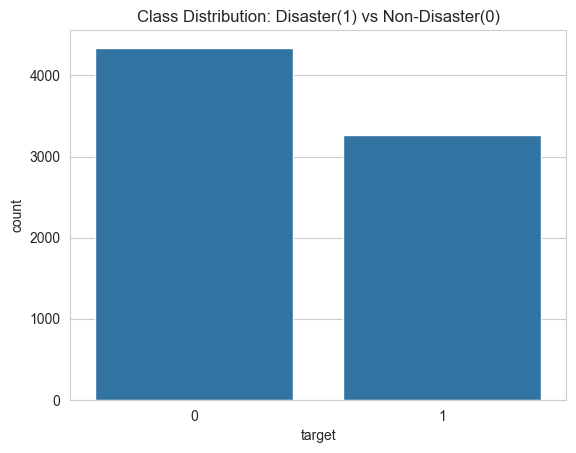

In [4]:
print_header("Class Balance")

# text
counts = train["target"].value_counts().sort_index()
props  = (counts / counts.sum() * 100).round(2)
summary = pd.DataFrame({"count": counts, "percent": props})
print(summary.to_string())

# plot
sns.countplot(x="target", data=train)
plt.title("Class Distribution: Disaster(1) vs Non-Disaster(0)")
plt.xlabel("target")
plt.ylabel("count")
plt.show()

### Missing value analysis
- Calculate and display the percentage of missing values per column
- Identify columns with significant missingness
- Visualize missing data distribution using a horizontal bar chart


Missing Values by Column
          percent_missing
location            33.27
keyword              0.80
id                   0.00
text                 0.00
target               0.00


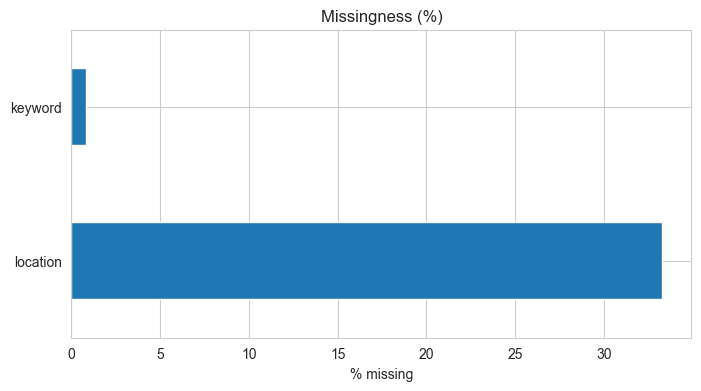

In [5]:
print_header("Missing Values by Column")

miss = train.isnull().mean().sort_values(ascending=False)
miss_tbl = (miss*100).round(2).rename("percent_missing").to_frame()
print(miss_tbl.to_string())

miss[miss>0].mul(100).plot(kind="barh", figsize=(8,4))
plt.xlabel("% missing")
plt.title("Missingness (%)")
plt.show()

### Keyword frequency analysis
- Display the 25 most common keywords across all tweets
- Visualize overall keyword frequency with a bar chart
- Compare top keywords between disaster and non-disaster tweets using stacked counts
- Identify terms strongly associated with disaster-related content


Top Keywords (Overall)
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
explosion      39
whirlwind      39
earthquake     39
derailment     39
wreckage       39


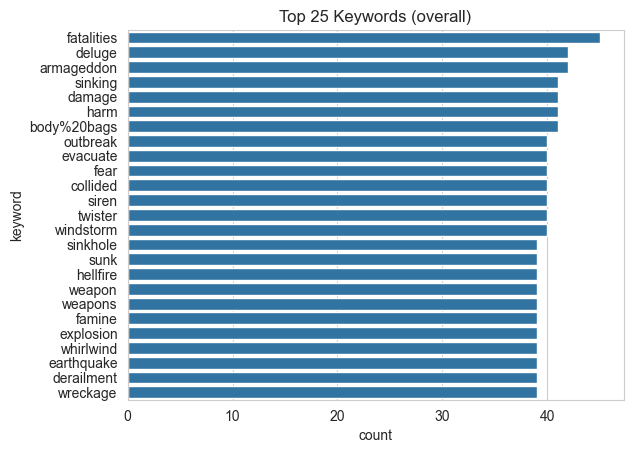


Top Keywords by Class (stacked counts)
target                 not_disaster  disaster
keyword                                      
derailment                        0        39
wreckage                          0        39
outbreak                          1        39
typhoon                           1        37
debris                            0        37
oil%20spill                       1        37
suicide%20bomb                    3        32
rescuers                          3        32
suicide%20bombing                 1        32
evacuated                         4        32
razed                             4        31
nuclear%20disaster                3        31
suicide%20bomber                  1        30
airplane%20accident               5        30
earthquake                        9        30
collision                        10        29
bridge%20collapse                 6        29
wildfire                          4        29
buildings%20on%20fire             5     

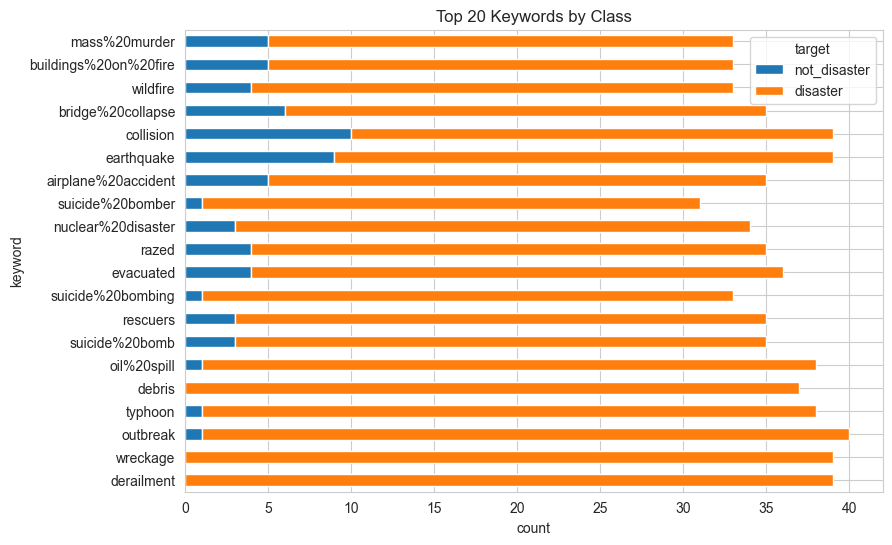

In [6]:
print_header("Top Keywords (Overall)")

kw_counts = train["keyword"].value_counts(dropna=True).head(25)
print(kw_counts.to_string())

sns.barplot(y=kw_counts.index, x=kw_counts.values)
plt.title("Top 25 Keywords (overall)")
plt.xlabel("count")
plt.ylabel("keyword")
plt.show()

print_header("Top Keywords by Class (stacked counts)")
kw_by_target = (train.dropna(subset=["keyword"])
                     .groupby(["keyword","target"])
                     .size()
                     .unstack(fill_value=0)
                     .rename(columns={0:"not_disaster",1:"disaster"}))
top_kw = kw_by_target.sort_values("disaster", ascending=False).head(20)
print(top_kw.to_string())

top_kw.plot(kind="barh", stacked=True, figsize=(9,6))
plt.title("Top 20 Keywords by Class")
plt.xlabel("count")
plt.show()

### Location frequency analysis
- Standardize and analyze the most common tweet locations
- Display the 20 most frequent locations overall
- Compare top locations between disaster and non-disaster tweets using stacked bar charts
- Identify geographic trends or regions frequently associated with disaster-related tweets


Top Locations (Overall)
location_clean
usa                 105
new york             77
london               50
united states        50
nigeria              35
canada               34
worldwide            31
uk                   30
india                28
los angeles, ca      28
mumbai               24
california           21
washington, dc       21
kenya                21
chicago, il          20
everywhere           20
australia            19
new york, ny         17
los angeles          16
washington, d.c.     15


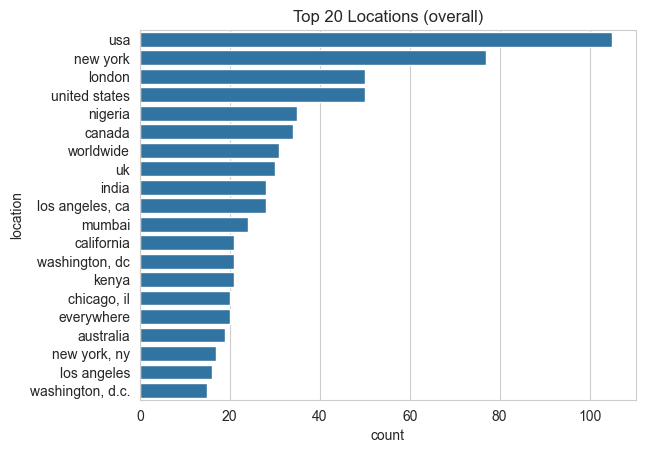


Top Locations by Class (stacked counts)
target            not_disaster  disaster
location_clean                          
usa                         38        67
nigeria                      7        28
united states               23        27
india                        6        22
mumbai                       5        19
worldwide                   12        19
new york                    59        18
canada                      17        17
uk                          13        17
london                      33        17
washington, dc               6        15
australia                    9        10
chicago, il                 10        10
washington, d.c.             5        10
earth                        5         9


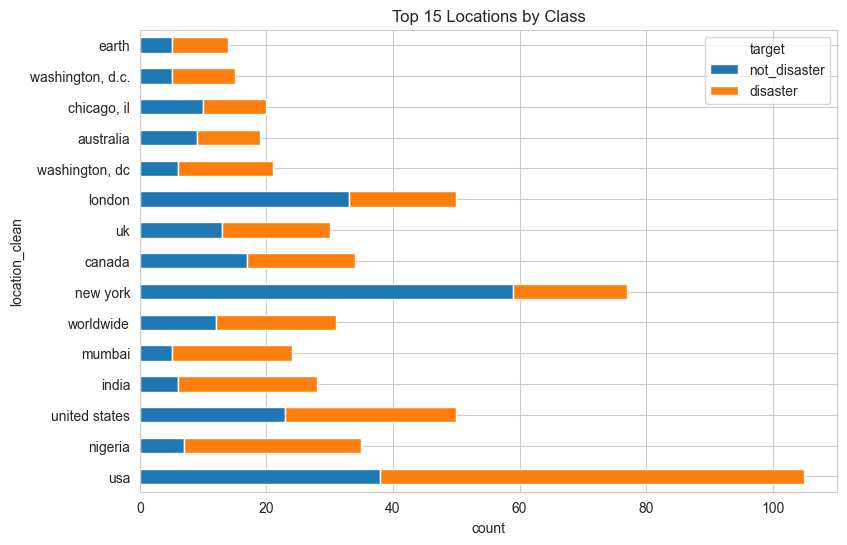

In [7]:
print_header("Top Locations (Overall)")

train["location_clean"] = train["location"].str.lower().str.strip()
loc_counts = train["location_clean"].value_counts(dropna=True).head(20)
print(loc_counts.to_string())

sns.barplot(y=loc_counts.index, x=loc_counts.values)
plt.title("Top 20 Locations (overall)")
plt.xlabel("count"); plt.ylabel("location")
plt.show()

print_header("Top Locations by Class (stacked counts)")
loc_by_target = (train.dropna(subset=["location_clean"])
                      .groupby(["location_clean","target"])
                      .size()
                      .unstack(fill_value=0)
                      .rename(columns={0:"not_disaster",1:"disaster"}))
top_loc = loc_by_target.sort_values("disaster", ascending=False).head(15)
print(top_loc.to_string())

top_loc.plot(kind="barh", stacked=True, figsize=(9,6))
plt.title("Top 15 Locations by Class")
plt.xlabel("count")
plt.show()

### Tweet length analysis
- Calculate descriptive statistics for tweet lengths (overall and by class)
- Compare text length distributions between disaster and non-disaster tweets
- Visualize character count distributions using histograms with KDE overlays
- Assess whether tweet length correlates with disaster-related content


Tweet Length (characters)
Overall length stats:
 count    7613.00
mean      101.04
std        33.78
min         7.00
10%        49.00
25%        78.00
50%       107.00
75%       133.00
90%       138.00
max       157.00 

By class length stats:
          count    mean    std   min   10%   25%    50%    75%    90%    max
target                                                                     
0       4342.0   95.71  35.89   7.0  43.0  68.0  101.0  130.0  138.0  157.0
1       3271.0  108.11  29.31  14.0  66.0  88.0  115.0  136.0  138.0  151.0


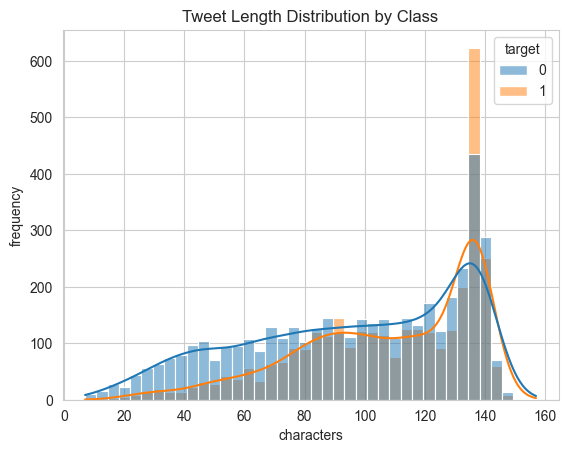

In [8]:
print_header("Tweet Length (characters)")

train["text_len"] = train["text"].str.len()

# text stats
stats_all = train["text_len"].describe(percentiles=[.1,.25,.5,.75,.9]).round(2)
print("Overall length stats:\n", stats_all.to_string(), "\n")

by_class = (train.groupby("target")["text_len"]
                 .describe(percentiles=[.1,.25,.5,.75,.9])
                 .round(2))
print("By class length stats:\n", by_class.to_string())

# plot
sns.histplot(data=train, x="text_len", hue="target", bins=40, kde=True)
plt.title("Tweet Length Distribution by Class")
plt.xlabel("characters"); plt.ylabel("frequency")
plt.show()

### TF-IDF keyword importance by class
- Compute TF-IDF scores separately for disaster (1) and non-disaster (0) tweets
- Identify top 25 discriminative words for each class
- Visualize high-weight terms to understand which words dominate each category
- Provides linguistic insight into features most predictive of disaster relevance


Top Words – Disaster Class (1)
http          0.058184
https         0.009909
û_            0.009397
news          0.009254
california    0.008767
disaster      0.008710
amp           0.008209
suicide       0.007761
like          0.007455
hiroshima     0.007317
people        0.007253
police        0.007026
storm         0.006975
fires         0.006903
crash         0.006720
families      0.006719
killed        0.006681
just          0.006615
mh370         0.006507
buildings     0.006307
wildfire      0.006042
train         0.006037
nuclear       0.005823
emergency     0.005796
bomb          0.005706


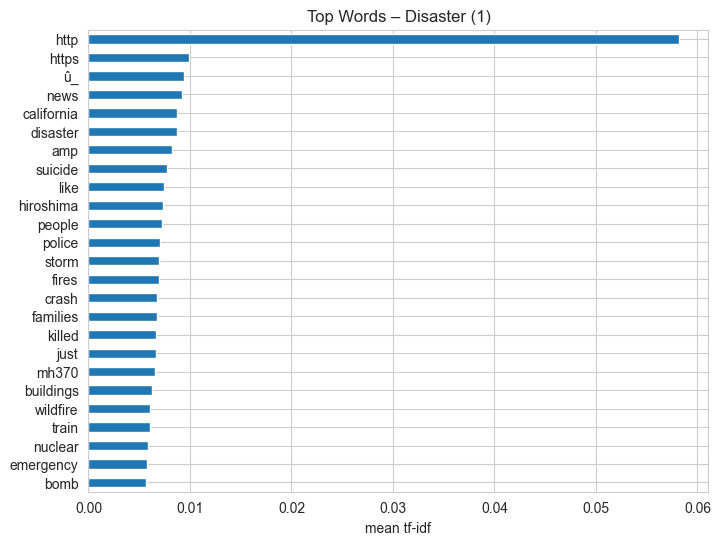


Top Words – Non-Disaster Class (0)
http         0.050451
https        0.015635
like         0.012968
just         0.012550
amp          0.009778
don          0.008464
new          0.008346
û_           0.007709
body         0.006803
love         0.006430
people       0.005876
know         0.005776
video        0.005752
got          0.005738
day          0.005523
time         0.005482
let          0.005113
emergency    0.005051
going        0.004983
youtube      0.004937
think        0.004775
good         0.004637
want         0.004514
lol          0.004509
man          0.004468


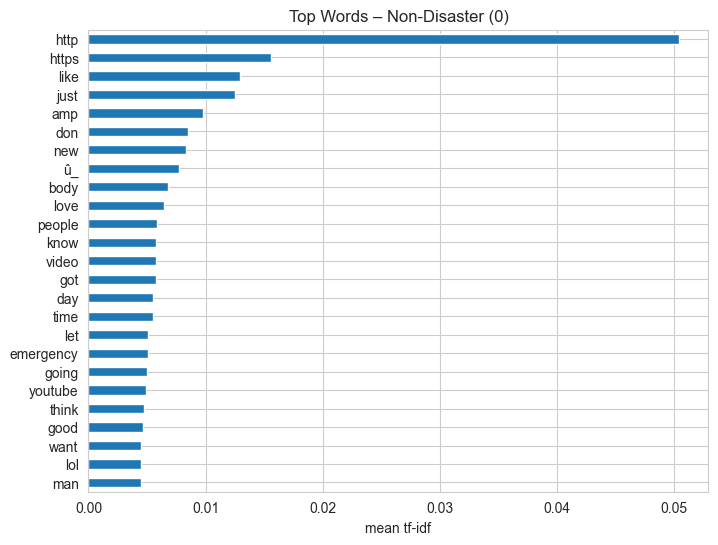

In [9]:
def class_tfidf_top(df, label, n=20):
    vec = TfidfVectorizer(stop_words="english", max_features=5000)
    X = vec.fit_transform(df.loc[df["target"]==label, "text"].fillna("").str.lower())
    means = np.asarray(X.mean(axis=0)).ravel()
    s = pd.Series(means, index=vec.get_feature_names_out()).sort_values(ascending=False).head(n)
    return s

print_header("Top Words – Disaster Class (1)")
top1 = class_tfidf_top(train, 1, n=25)
print(top1.to_string())
top1.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Top Words – Disaster (1)")
plt.xlabel("mean tf-idf")
plt.show()

print_header("Top Words – Non-Disaster Class (0)")
top0 = class_tfidf_top(train, 0, n=25)
print(top0.to_string())
top0.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Top Words – Non-Disaster (0)")
plt.xlabel("mean tf-idf")
plt.show()

### EDA summary snapshot

In [11]:
print_header("EDA One-Pager Summary")

lines = []

# dataset size
n_train = len(train); n_test = len(test)
pos = int(train["target"].sum()); neg = n_train - pos
lines.append(f"Rows: train={n_train}, test={n_test}. Class balance: 1s={pos} ({pos/n_train:.1%}), 0s={neg} ({neg/n_train:.1%}).")

# missingness
mk = train["keyword"].isna().mean()
ml = train["location"].isna().mean()
lines.append(f"Missing: keyword={mk:.1%}, location={ml:.1%} (others ~0%).")

# lengths
lens = train["text_len"].describe().to_dict()
lines.append(f"Tweet length (chars): mean={lens['mean']:.1f}, median={lens['50%']:.0f}, IQR≈{lens['75%']-lens['25%']:.0f}.")

# top signals
lines.append(f"Top words (1): {', '.join(top1.index[:8])}")
lines.append(f"Top words (0): {', '.join(top0.index[:8])}")

print("\n".join(lines))


EDA One-Pager Summary
Rows: train=7613, test=3263. Class balance: 1s=3271 (43.0%), 0s=4342 (57.0%).
Missing: keyword=0.8%, location=33.3% (others ~0%).
Tweet length (chars): mean=101.0, median=107, IQR≈55.
Top words (1): http, https, û_, news, california, disaster, amp, suicide
Top words (0): http, https, like, just, amp, don, new, û_


## 🧠 Model Architecture

### 1️⃣ Text Representation: TF-IDF

To transform raw tweet text into numeric features, I used the **Term Frequency–Inverse Document Frequency (TF-IDF)** method.

TF-IDF converts each document (tweet) into a sparse vector of weighted word counts. It captures how important a word is within a tweet *relative* to its frequency across all tweets.

- **Term Frequency (TF):** Measures how often a word appears in a single tweet.
- **Inverse Document Frequency (IDF):** Reduces the weight of common words that appear in many tweets (e.g., “the”, “and”).
- **Combined Formula:**

`P(y=1|x) = 1 / (1 + exp(-(w · x + b)))`
  where \( N \) is the total number of documents and \( \text{DF}(w) \) is the number of documents containing word \( w \).

This approach preserves semantic signal through word frequency while limiting noise from overly common words.
I used a **1–2 gram** range and **10,000 features**, which helps capture short phrases such as “fire alarm” or “earth quake” that can be strongly indicative of real disasters.

---

### 2️⃣ Baseline Model: Logistic Regression

My first model was a **Logistic Regression classifier** trained on the TF-IDF feature matrix. Logistic Regression is a simple yet powerful linear model for binary text classification.

Each feature (word or bigram) receives a learned weight, and the model computes the probability of the tweet being about a disaster via the logistic function:

\[
P(y=1|x) = \frac{1}{1 + e^{-(w \cdot x + b)}}
\]

This architecture is well-suited to sparse high-dimensional data and provides interpretability through feature coefficients (e.g., positive weights for words like “earthquake” or “flood,” negative for “lol” or “party”).

---

### 3️⃣ Sequential Neural Network: Bidirectional LSTM

To explore a deep learning approach, I also built a **Bidirectional Long Short-Term Memory (BiLSTM)** network.
Tweets often contain contextual clues and sequential dependencies that bag-of-words models ignore — for example, “not a fire” has opposite meaning from “a fire.”
RNNs and their variants (LSTM, GRU) are designed to capture these sequential relationships.

- **Embedding Layer:** Maps each word to a dense 64-dimensional vector. This acts like a learned word-embedding space where similar words (e.g., *storm*, *hurricane*) end up close together.
- **Bidirectional LSTM Layer:** Processes the tweet from both left-to-right and right-to-left to capture context before and after each word.
- **Dropout Layer:** Randomly disables neurons during training to reduce overfitting.
- **Dense ReLU Layer:** Adds nonlinear combinations of learned features.
- **Output Layer (Sigmoid):** Produces a probability between 0 and 1 for the disaster label.

**Model Summary (Keras):**

In [12]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelwalker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Text Cleaning & Save Cleaned Data
- Lowercase, strip URLs, mentions, hashtags, and non-letters.
- Remove stopwords; apply Porter stemming.
- Create `clean_text` for train/test; compute token counts (`clean_len`).
- Quick sanity check: sample original vs cleaned rows.
- Plot token count histogram to inspect distribution.
- Persist cleaned files:
  - `data/train_clean.csv`
  - `data/test_clean.csv`

Cleaning text fields...
                                                                                                                               text  \
2644                                                             So you have a new weapon that can cause un-imaginable destruction.   
2227        The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@   
5448  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q   
132              Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.   
6845                      in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3   

                                                                         clean_text  
2644                                              new weapon caus unimagin dest

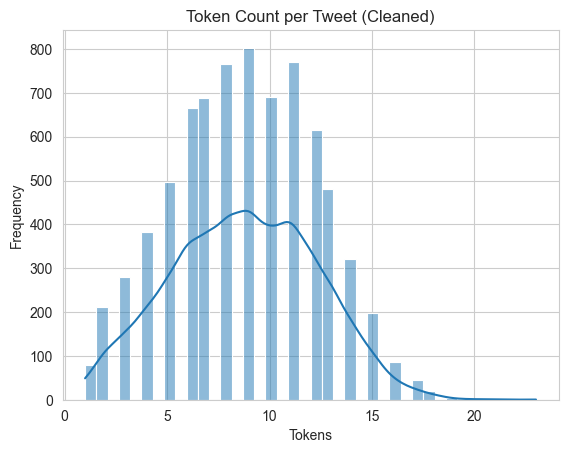

Example cleaned tweets:

Original: @KatieKatCubs you already know how this shit goes. World Series or Armageddon.
Cleaned: alreadi know shit goe world seri armageddon
---
Original: @LeMaireLee @danharmon People Near Meltdown Comics Who Have Free Time to Wait in Line on Sunday Nights are not a representative sample. #140
Cleaned: peopl near meltdown comic free time wait line sunday night repres sampl
---
Original: 1-6 TIX Calgary Flames vs COL Avalanche Preseason 9/29 Scotiabank Saddledome http://t.co/5G8qA6mPxm
Cleaned: tix calgari flame vs col avalanch preseason scotiabank saddledom
---
Original: If you ever think you running out of choices in life rembr there's that kid that has no choice but wear a suicide bomb vest
Cleaned: ever think run choic life rembr there kid choic wear suicid bomb vest
---
Original: If you dotish to blight your car go right ahead. Once it's not mine.
Cleaned: dotish blight car go right ahead mine
---


In [13]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # URLs
    text = re.sub(r'@\w+|#', '', text)                   # mentions/hashtags
    text = re.sub(r'[^a-z\s]', '', text)                 # remove numbers/punct
    tokens = [stemmer.stem(w) for w in text.split() if w not in stop]
    return " ".join(tokens)

print("Cleaning text fields...")

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text']  = test['text'].apply(clean_text)

# quick check
print(train[['text','clean_text']].sample(5, random_state=42))

train['clean_len'] = train['clean_text'].str.split().apply(len)
print(train['clean_len'].describe())

sns.histplot(train['clean_len'], bins=40, kde=True)
plt.title("Token Count per Tweet (Cleaned)")
plt.xlabel("Tokens"); plt.ylabel("Frequency")
plt.show()

train.to_csv("/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/Week 4/data/train_clean.csv", index=False)
test.to_csv("/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/Week 4/data/test_clean.csv", index=False)

print("Example cleaned tweets:\n")
for _, row in train.sample(5, random_state=0).iterrows():
    print(f"Original: {row.text}\nCleaned: {row.clean_text}\n---")

### TF-IDF Vectorization & Split
- Build 1–2 gram TF-IDF features (`max_features=10k`) on `clean_text`.
- Keep prior cleaning (stopword removal + stemming); no extra stopword filter here.
- Create train/validation split (80/20, stratified, `random_state=42`).
- Print sparse matrix shapes to confirm feature dimensionality.

In [14]:


print("Vectorizing with TF-IDF…")

# You already removed stopwords/stemmed, so we won’t remove stopwords again.
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = vectorizer.fit_transform(train['clean_text'])
y = train['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shapes:", X_train.shape, X_val.shape)

Vectorizing with TF-IDF…
Shapes: (6090, 10000) (1523, 10000)


### Baseline: TF-IDF + Logistic Regression
- Train a Logistic Regression classifier (`max_iter=2000`) on the TF-IDF features.
- Evaluate on the validation set:
  - Accuracy, classification report, confusion matrix (with heatmap).
  - ROC curve and ROC-AUC score.
- Tune decision threshold via **Youden’s J** (argmax of TPR − FPR) and re-report metrics.
- Inspect model interpretability:
  - Show top positive/negative coefficient terms (most indicative for disaster vs non-disaster).

Accuracy: 0.8168089297439265

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       869
           1       0.85      0.70      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523


Confusion Matrix:
 [[789  80]
 [199 455]]


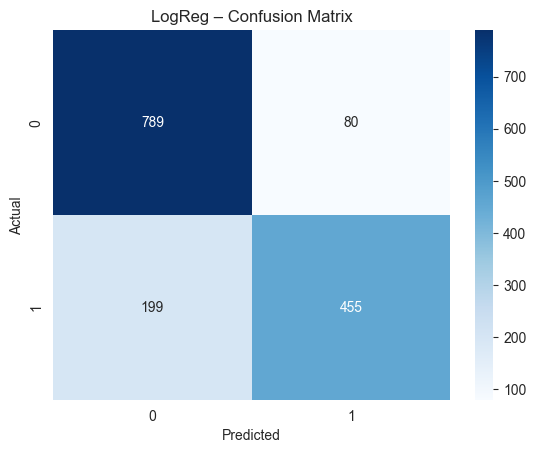

ROC-AUC: 0.8709


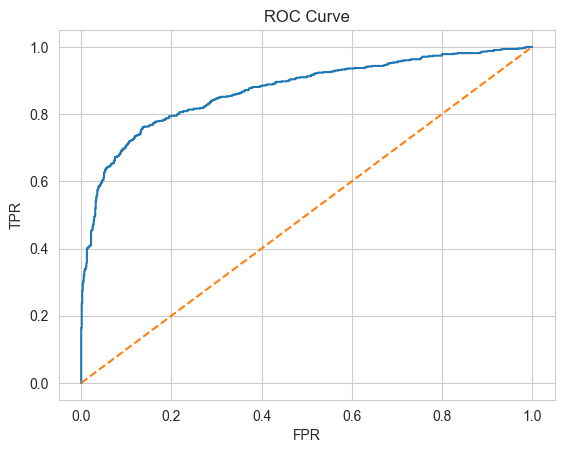

Youden’s J best threshold: 0.452

Report @ tuned threshold:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       869
           1       0.81      0.76      0.78       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523


Top terms → DISASTER (class 1):
debri                     1.703
migrant                   1.736
japan                     1.770
tornado                   1.788
massacr                   1.852
near                      1.891
build                     1.904
sever                     1.929
suicid                    2.093
polic                     2.115
earthquak                 2.173
storm                     2.252
train                     2.304
evacu                     2.333
flood                     2.438
wildfir                   2.549
california                2.602
kill                      2.832
hir

In [15]:

model_lr = LogisticRegression(max_iter=2000, n_jobs=-1)
model_lr.fit(X_train, y_train)

preds_val = model_lr.predict(X_val)
probs_val = model_lr.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val, preds_val))
print("\nClassification Report:\n", classification_report(y_val, preds_val))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, preds_val))

cm = confusion_matrix(y_val, preds_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("LogReg – Confusion Matrix")
plt.show()

auc = roc_auc_score(y_val, probs_val)
print("ROC-AUC:", round(auc, 4))

fpr, tpr, thr = roc_curve(y_val, probs_val)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
plt.show()

# choose threshold that balances precision/recall (example: 0.5 vs argmax of Youden's J)
youden_idx = (tpr - fpr).argmax()
best_thr = thr[youden_idx]
print("Youden’s J best threshold:", round(float(best_thr), 3))

tuned_preds = (probs_val >= best_thr).astype(int)
print("\nReport @ tuned threshold:\n", classification_report(y_val, tuned_preds))

feat_names = np.array(vectorizer.get_feature_names_out())
coef = model_lr.coef_.ravel()

top_pos_idx = np.argsort(coef)[-20:]
top_neg_idx = np.argsort(coef)[:20]

print("\nTop terms → DISASTER (class 1):")
for f, c in zip(feat_names[top_pos_idx], coef[top_pos_idx]):
    print(f"{f:<25} {c:.3f}")

print("\nTop terms → NON-DISASTER (class 0):")
for f, c in zip(feat_names[top_neg_idx], coef[top_neg_idx]):
    print(f"{f:<25} {c:.3f}")

### Train/Val Split & Tokenization (for Neural Models)
- Set seeds for reproducibility and create a **stratified** train/validation split on cleaned text.
- Build a Keras `Tokenizer` capped at **20k words** with an `<OOV>` token.
- Define `texts_to_pad()` helper to convert text → sequences → **padded** arrays.
- Initialize sequences using a compact default **max length = 32** (tuned later).

In [16]:


# ---- reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)

X_text = train["clean_text"].fillna("").astype(str).values
y      = train["target"].values

X_tr_text, X_val_text, y_tr, y_val = train_test_split(
    X_text, y, test_size=0.2, random_state=SEED, stratify=y
)


# NumPy 2.0 shim for keras_preprocessing
if not hasattr(np, "unicode_"):
    np.unicode_ = np.str_

MAX_WORDS = 20000
tok = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tok.fit_on_texts(X_tr_text)

def texts_to_pad(texts, max_len=32):
    seqs = tok.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=max_len, truncating="post", padding="post")

# short tweets → start modest; we’ll sweep this too
MAX_LEN_DEFAULT = 32
X_tr_seq  = texts_to_pad(X_tr_text, MAX_LEN_DEFAULT)
X_val_seq = texts_to_pad(X_val_text, MAX_LEN_DEFAULT)

### Baseline Neural Model: FastText-style Averaging
- Build a compact neural baseline: **Embedding → GlobalAveragePooling → (Dropout) → Sigmoid**.
- Purpose: fast, low-variance benchmark that captures bag-of-embeddings signal.
- Training: `epochs=10`, `batch_size=64`, with **EarlyStopping** on `val_loss` (patience=2).
- Evaluation: prints **Accuracy, F1, Precision, Recall, ROC-AUC**; also plots **ROC curve** and **confusion matrix**.
- Reproducibility: seeds set via `tf.keras.utils.set_random_seed(SEED)`.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-10-23 09:08:26.018767: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-10-23 09:08:26.019268: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-23 09:08:26.019276: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-23 09:08:26.019639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-23 09:08:26.019743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus

Epoch 1/10


2025-10-23 09:08:26.700755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


96/96 - 3s - 31ms/step - accuracy: 0.5708 - loss: 0.6749 - val_accuracy: 0.5719 - val_loss: 0.6663
Epoch 2/10
96/96 - 2s - 19ms/step - accuracy: 0.5954 - loss: 0.6491 - val_accuracy: 0.6815 - val_loss: 0.6344
Epoch 3/10
96/96 - 2s - 19ms/step - accuracy: 0.7044 - loss: 0.6011 - val_accuracy: 0.7748 - val_loss: 0.5863
Epoch 4/10
96/96 - 2s - 20ms/step - accuracy: 0.7819 - loss: 0.5383 - val_accuracy: 0.8011 - val_loss: 0.5358
Epoch 5/10
96/96 - 2s - 22ms/step - accuracy: 0.8212 - loss: 0.4784 - val_accuracy: 0.8109 - val_loss: 0.4973
Epoch 6/10
96/96 - 2s - 23ms/step - accuracy: 0.8463 - loss: 0.4285 - val_accuracy: 0.8155 - val_loss: 0.4717
Epoch 7/10
96/96 - 2s - 21ms/step - accuracy: 0.8571 - loss: 0.3894 - val_accuracy: 0.8221 - val_loss: 0.4557
Epoch 8/10
96/96 - 2s - 25ms/step - accuracy: 0.8704 - loss: 0.3573 - val_accuracy: 0.8148 - val_loss: 0.4469
Epoch 9/10
96/96 - 2s - 24ms/step - accuracy: 0.8808 - loss: 0.3321 - val_accuracy: 0.8181 - val_loss: 0.4422
Epoch 10/10
96/96 - 2

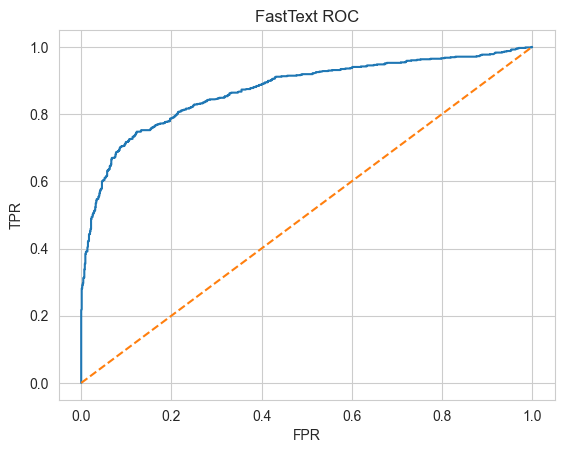

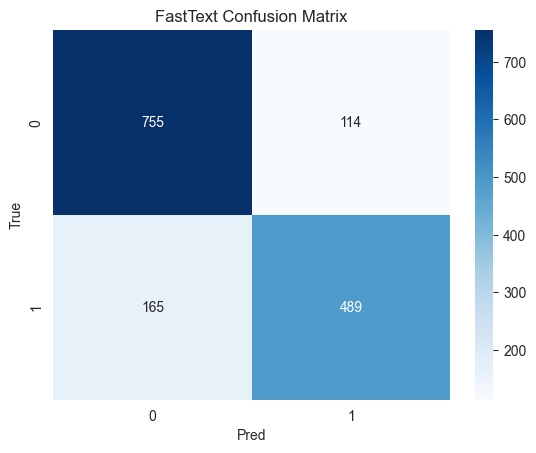

In [17]:
def make_fasttext(max_words=MAX_WORDS, max_len=MAX_LEN_DEFAULT, emb=64, l2=0.0, drop=0.0):
    inp = Input(shape=(max_len,))
    x = layers.Embedding(max_words, emb, input_length=max_len)(inp)
    x = layers.GlobalAveragePooling1D()(x)
    if drop > 0: x = layers.Dropout(drop)(x)
    out = layers.Dense(1, activation="sigmoid",
                       kernel_regularizer=regularizers.l2(l2) if l2>0 else None)(x)
    model = Model(inp, out)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

def evaluate_model(model, Xv, yv, title=""):
    p = model.predict(Xv, verbose=0).ravel()
    yhat = (p >= 0.5).astype(int)
    acc = accuracy_score(yv, yhat)
    pr, rc, f1, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
    auc = roc_auc_score(yv, p)
    print(f"{title}  acc={acc:.4f}  f1={f1:.4f}  prec={pr:.4f}  rec={rc:.4f}  auc={auc:.4f}")
    return {"accuracy":acc, "f1":f1, "precision":pr, "recall":rc, "roc_auc":auc}

tf.keras.utils.set_random_seed(SEED)
ft = make_fasttext(emb=64, l2=0.0, drop=0.1, max_len=MAX_LEN_DEFAULT)
hist = ft.fit(X_tr_seq, y_tr, validation_data=(X_val_seq, y_val),
              epochs=10, batch_size=64,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)],
              verbose=2)
base_metrics = evaluate_model(ft, X_val_seq, y_val, "FastText-64d")

p = ft.predict(X_val_seq, verbose=0).ravel()
fpr, tpr, _ = roc_curve(y_val, p)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title("FastText ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

cm = confusion_matrix(y_val, (p>=0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title("FastText Confusion Matrix"); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

### Hyperparameter Sweep: FastText Baseline
- **Goal:** Systematically test embedding size, sequence length, dropout, and L2 to improve the FastText-style model.
- **Grid:**
  - `emb ∈ {32, 64, 128}`
  - `max_len ∈ {24, 32, 48}`
  - `drop ∈ {0.0, 0.2}`
  - `l2 ∈ {0.0, 1e-4}`
- **Procedure:** For each combo, re-pad sequences, rebuild the model, train for up to 8 epochs with **EarlyStopping** (on `val_loss`, patience=2), and log metrics.
- **Metrics:** Accuracy, F1, Precision, Recall, ROC-AUC; track `best_epoch` from validation loss.
- **Visualization:** Bar plots of **F1** vs `emb`, `max_len`, and `drop` to interpret sensitivity.
- **Output:** `df_ft` sorted by F1 (top 10 shown) and `best_ft_cfg` with the best configuration.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
96/96 - 4s - 44ms/step - accuracy: 0.5706 - loss: 0.6741 - val_accuracy: 0.5726 - val_loss: 0.6663
Epoch 2/8
96/96 - 3s - 29ms/step - accuracy: 0.5878 - loss: 0.6508 - val_accuracy: 0.6573 - val_loss: 0.6402
Epoch 3/8
96/96 - 2s - 23ms/step - accuracy: 0.6813 - loss: 0.6105 - val_accuracy: 0.7439 - val_loss: 0.5991
Epoch 4/8
96/96 - 3s - 28ms/step - accuracy: 0.7675 - loss: 0.5557 - val_accuracy: 0.7997 - val_loss: 0.5545
Epoch 5/8
96/96 - 2s - 18ms/step - accuracy: 0.8141 - loss: 0.4996 - val_accuracy: 0.8063 - val_loss: 0.5173
Epoch 6/8
96/96 - 2s - 17ms/step - accuracy: 0.8409 - loss: 0.4509 - val_accuracy: 0.8129 - val_loss: 0.4905
Epoch 7/8
96/96 - 2s - 26ms/step - accuracy: 0.8548 - loss: 0.4111 - val_accuracy: 0.8122 - val_loss: 0.4724
Epoch 8/8
96/96 - 2s - 17ms/step - accuracy: 0.8655 - loss: 0.3788 - val_accuracy: 0.8129 - val_loss: 0.4607
FT emb=32 len=24 drop=0.0 l2=0.0  acc=0.8129  f1=0.7743  prec=0.8030  rec=0.7477  auc=0.8713
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 3s - 30ms/step - accuracy: 0.5706 - loss: 0.6743 - val_accuracy: 0.5726 - val_loss: 0.6666
Epoch 2/8
96/96 - 2s - 17ms/step - accuracy: 0.5874 - loss: 0.6513 - val_accuracy: 0.6553 - val_loss: 0.6409
Epoch 3/8
96/96 - 2s - 18ms/step - accuracy: 0.6806 - loss: 0.6115 - val_accuracy: 0.7439 - val_loss: 0.6003
Epoch 4/8
96/96 - 2s - 19ms/step - accuracy: 0.7662 - loss: 0.5572 - val_accuracy: 0.7991 - val_loss: 0.5561
Epoch 5/8
96/96 - 3s - 31ms/step - accuracy: 0.8135 - loss: 0.5016 - val_accuracy: 0.8056 - val_loss: 0.5193
Epoch 6/8
96/96 - 2s - 26ms/step - accuracy: 0.8402 - loss: 0.4533 - val_accuracy: 0.8129 - val_loss: 0.4928
Epoch 7/8
96/96 - 3s - 28ms/step - accuracy: 0.8544 - loss: 0.4141 - val_accuracy: 0.8116 - val_loss: 0.4751
Epoch 8/8
96/96 - 2s - 26ms/step - accuracy: 0.8649 - loss: 0.3823 - val_accuracy: 0.8129 - val_loss: 0.4639
FT emb=32 len=24 drop=0.0 l2=0.0001  acc=0.8129  f1=0.7743  prec=0.8030  rec=0.7477  auc=0.8713
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 37ms/step - accuracy: 0.5708 - loss: 0.6749 - val_accuracy: 0.5719 - val_loss: 0.6678
Epoch 2/8
96/96 - 2s - 17ms/step - accuracy: 0.5826 - loss: 0.6552 - val_accuracy: 0.6422 - val_loss: 0.6451
Epoch 3/8
96/96 - 2s - 17ms/step - accuracy: 0.6644 - loss: 0.6192 - val_accuracy: 0.7288 - val_loss: 0.6086
Epoch 4/8
96/96 - 2s - 17ms/step - accuracy: 0.7534 - loss: 0.5705 - val_accuracy: 0.7892 - val_loss: 0.5667
Epoch 5/8
96/96 - 2s - 17ms/step - accuracy: 0.8020 - loss: 0.5183 - val_accuracy: 0.8070 - val_loss: 0.5292
Epoch 6/8
96/96 - 2s - 18ms/step - accuracy: 0.8304 - loss: 0.4702 - val_accuracy: 0.8155 - val_loss: 0.5008
Epoch 7/8
96/96 - 2s - 19ms/step - accuracy: 0.8486 - loss: 0.4299 - val_accuracy: 0.8168 - val_loss: 0.4796
Epoch 8/8
96/96 - 3s - 28ms/step - accuracy: 0.8576 - loss: 0.3970 - val_accuracy: 0.8116 - val_loss: 0.4658
FT emb=32 len=24 drop=0.2 l2=0.0  acc=0.8116  f1=0.7698  prec=0.8094  rec=0.7339  auc=0.8708
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 5s - 47ms/step - accuracy: 0.5706 - loss: 0.6751 - val_accuracy: 0.5719 - val_loss: 0.6681
Epoch 2/8
96/96 - 2s - 25ms/step - accuracy: 0.5823 - loss: 0.6557 - val_accuracy: 0.6408 - val_loss: 0.6458
Epoch 3/8
96/96 - 3s - 29ms/step - accuracy: 0.6624 - loss: 0.6202 - val_accuracy: 0.7295 - val_loss: 0.6098
Epoch 4/8
96/96 - 2s - 25ms/step - accuracy: 0.7517 - loss: 0.5720 - val_accuracy: 0.7886 - val_loss: 0.5684
Epoch 5/8
96/96 - 3s - 29ms/step - accuracy: 0.8015 - loss: 0.5203 - val_accuracy: 0.8076 - val_loss: 0.5312
Epoch 6/8
96/96 - 3s - 29ms/step - accuracy: 0.8305 - loss: 0.4727 - val_accuracy: 0.8148 - val_loss: 0.5032
Epoch 7/8
96/96 - 4s - 41ms/step - accuracy: 0.8488 - loss: 0.4329 - val_accuracy: 0.8168 - val_loss: 0.4823
Epoch 8/8
96/96 - 3s - 29ms/step - accuracy: 0.8573 - loss: 0.4004 - val_accuracy: 0.8122 - val_loss: 0.4690
FT emb=32 len=24 drop=0.2 l2=0.0001  acc=0.8122  f1=0.7705  prec=0.8108  rec=0.7339  auc=0.8708
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 46ms/step - accuracy: 0.5703 - loss: 0.6768 - val_accuracy: 0.5706 - val_loss: 0.6713
Epoch 2/8
96/96 - 2s - 24ms/step - accuracy: 0.5754 - loss: 0.6607 - val_accuracy: 0.6093 - val_loss: 0.6532
Epoch 3/8
96/96 - 3s - 29ms/step - accuracy: 0.6284 - loss: 0.6322 - val_accuracy: 0.7058 - val_loss: 0.6225
Epoch 4/8
96/96 - 2s - 26ms/step - accuracy: 0.7233 - loss: 0.5896 - val_accuracy: 0.7768 - val_loss: 0.5845
Epoch 5/8
96/96 - 3s - 29ms/step - accuracy: 0.7865 - loss: 0.5404 - val_accuracy: 0.8096 - val_loss: 0.5477
Epoch 6/8
96/96 - 2s - 17ms/step - accuracy: 0.8163 - loss: 0.4929 - val_accuracy: 0.8109 - val_loss: 0.5166
Epoch 7/8
96/96 - 2s - 22ms/step - accuracy: 0.8411 - loss: 0.4517 - val_accuracy: 0.8122 - val_loss: 0.4926
Epoch 8/8
96/96 - 3s - 27ms/step - accuracy: 0.8548 - loss: 0.4171 - val_accuracy: 0.8129 - val_loss: 0.4752
FT emb=32 len=32 drop=0.0 l2=0.0  acc=0.8129  f1=0.7685  prec=0.8198  rec=0.7232  auc=0.8704


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
96/96 - 5s - 51ms/step - accuracy: 0.5703 - loss: 0.6770 - val_accuracy: 0.5706 - val_loss: 0.6716
Epoch 2/8
96/96 - 3s - 33ms/step - accuracy: 0.5750 - loss: 0.6611 - val_accuracy: 0.6047 - val_loss: 0.6538
Epoch 3/8
96/96 - 3s - 36ms/step - accuracy: 0.6273 - loss: 0.6332 - val_accuracy: 0.7058 - val_loss: 0.6236
Epoch 4/8
96/96 - 3s - 28ms/step - accuracy: 0.7225 - loss: 0.5911 - val_accuracy: 0.7715 - val_loss: 0.5861
Epoch 5/8
96/96 - 2s - 23ms/step - accuracy: 0.7851 - loss: 0.5424 - val_accuracy: 0.8089 - val_loss: 0.5497
Epoch 6/8
96/96 - 2s - 23ms/step - accuracy: 0.8164 - loss: 0.4954 - val_accuracy: 0.8102 - val_loss: 0.5191
Epoch 7/8
96/96 - 3s - 28ms/step - accuracy: 0.8401 - loss: 0.4547 - val_accuracy: 0.8122 - val_loss: 0.4956
Epoch 8/8
96/96 - 2s - 22ms/step - accuracy: 0.8540 - loss: 0.4206 - val_accuracy: 0.8129 - val_loss: 0.4786
FT emb=32 len=32 drop=0.0 l2=0.0001  acc=0.8129  f1=0.7685  prec=0.8198  rec=0.7232  auc=0.8704
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 40ms/step - accuracy: 0.5706 - loss: 0.6773 - val_accuracy: 0.5706 - val_loss: 0.6724
Epoch 2/8
96/96 - 3s - 32ms/step - accuracy: 0.5732 - loss: 0.6640 - val_accuracy: 0.5975 - val_loss: 0.6568
Epoch 3/8
96/96 - 3s - 31ms/step - accuracy: 0.6161 - loss: 0.6387 - val_accuracy: 0.6894 - val_loss: 0.6301
Epoch 4/8
96/96 - 2s - 26ms/step - accuracy: 0.7041 - loss: 0.6019 - val_accuracy: 0.7597 - val_loss: 0.5957
Epoch 5/8
96/96 - 2s - 23ms/step - accuracy: 0.7703 - loss: 0.5579 - val_accuracy: 0.7997 - val_loss: 0.5606
Epoch 6/8
96/96 - 2s - 24ms/step - accuracy: 0.8069 - loss: 0.5128 - val_accuracy: 0.8096 - val_loss: 0.5302
Epoch 7/8
96/96 - 2s - 22ms/step - accuracy: 0.8310 - loss: 0.4721 - val_accuracy: 0.8148 - val_loss: 0.5049
Epoch 8/8
96/96 - 3s - 26ms/step - accuracy: 0.8452 - loss: 0.4371 - val_accuracy: 0.8135 - val_loss: 0.4858
FT emb=32 len=32 drop=0.2 l2=0.0  acc=0.8135  f1=0.7684  prec=0.8234  rec=0.7202  auc=0.8698
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 5s - 48ms/step - accuracy: 0.5706 - loss: 0.6775 - val_accuracy: 0.5706 - val_loss: 0.6727
Epoch 2/8
96/96 - 2s - 21ms/step - accuracy: 0.5731 - loss: 0.6644 - val_accuracy: 0.5929 - val_loss: 0.6574
Epoch 3/8
96/96 - 2s - 22ms/step - accuracy: 0.6146 - loss: 0.6396 - val_accuracy: 0.6894 - val_loss: 0.6311
Epoch 4/8
96/96 - 2s - 24ms/step - accuracy: 0.7031 - loss: 0.6033 - val_accuracy: 0.7571 - val_loss: 0.5973
Epoch 5/8
96/96 - 2s - 21ms/step - accuracy: 0.7685 - loss: 0.5599 - val_accuracy: 0.7997 - val_loss: 0.5626
Epoch 6/8
96/96 - 2s - 21ms/step - accuracy: 0.8059 - loss: 0.5153 - val_accuracy: 0.8089 - val_loss: 0.5327
Epoch 7/8
96/96 - 2s - 20ms/step - accuracy: 0.8307 - loss: 0.4751 - val_accuracy: 0.8148 - val_loss: 0.5078
Epoch 8/8
96/96 - 2s - 21ms/step - accuracy: 0.8448 - loss: 0.4406 - val_accuracy: 0.8122 - val_loss: 0.4892
FT emb=32 len=32 drop=0.2 l2=0.0001  acc=0.8122  f1=0.7663  prec=0.8228  rec=0.7171  auc=0.8698
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 39ms/step - accuracy: 0.5703 - loss: 0.6793 - val_accuracy: 0.5706 - val_loss: 0.6758
Epoch 2/8
96/96 - 3s - 27ms/step - accuracy: 0.5704 - loss: 0.6697 - val_accuracy: 0.5719 - val_loss: 0.6653
Epoch 3/8
96/96 - 3s - 27ms/step - accuracy: 0.5869 - loss: 0.6534 - val_accuracy: 0.6422 - val_loss: 0.6469
Epoch 4/8
96/96 - 3s - 27ms/step - accuracy: 0.6534 - loss: 0.6268 - val_accuracy: 0.7341 - val_loss: 0.6208
Epoch 5/8
96/96 - 3s - 29ms/step - accuracy: 0.7284 - loss: 0.5913 - val_accuracy: 0.7610 - val_loss: 0.5885
Epoch 6/8
96/96 - 2s - 25ms/step - accuracy: 0.7747 - loss: 0.5519 - val_accuracy: 0.7715 - val_loss: 0.5563
Epoch 7/8
96/96 - 3s - 27ms/step - accuracy: 0.8057 - loss: 0.5127 - val_accuracy: 0.7853 - val_loss: 0.5284
Epoch 8/8
96/96 - 2s - 26ms/step - accuracy: 0.8284 - loss: 0.4766 - val_accuracy: 0.7997 - val_loss: 0.5052
FT emb=32 len=48 drop=0.0 l2=0.0  acc=0.7997  f1=0.7215  prec=0.8957  rec=0.6040  auc=0.8687
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 38ms/step - accuracy: 0.5703 - loss: 0.6795 - val_accuracy: 0.5706 - val_loss: 0.6761
Epoch 2/8
96/96 - 2s - 26ms/step - accuracy: 0.5704 - loss: 0.6701 - val_accuracy: 0.5719 - val_loss: 0.6658
Epoch 3/8
96/96 - 2s - 24ms/step - accuracy: 0.5865 - loss: 0.6541 - val_accuracy: 0.6395 - val_loss: 0.6478
Epoch 4/8
96/96 - 2s - 25ms/step - accuracy: 0.6514 - loss: 0.6281 - val_accuracy: 0.7321 - val_loss: 0.6222
Epoch 5/8
96/96 - 2s - 24ms/step - accuracy: 0.7278 - loss: 0.5932 - val_accuracy: 0.7610 - val_loss: 0.5906
Epoch 6/8
96/96 - 2s - 25ms/step - accuracy: 0.7732 - loss: 0.5543 - val_accuracy: 0.7722 - val_loss: 0.5588
Epoch 7/8
96/96 - 2s - 24ms/step - accuracy: 0.8049 - loss: 0.5157 - val_accuracy: 0.7853 - val_loss: 0.5314
Epoch 8/8
96/96 - 3s - 30ms/step - accuracy: 0.8284 - loss: 0.4802 - val_accuracy: 0.7991 - val_loss: 0.5087
FT emb=32 len=48 drop=0.0 l2=0.0001  acc=0.7991  f1=0.7203  prec=0.8955  rec=0.6024  auc=0.8687
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 5s - 47ms/step - accuracy: 0.5706 - loss: 0.6796 - val_accuracy: 0.5706 - val_loss: 0.6765
Epoch 2/8
96/96 - 2s - 25ms/step - accuracy: 0.5703 - loss: 0.6721 - val_accuracy: 0.5706 - val_loss: 0.6676
Epoch 3/8
96/96 - 3s - 28ms/step - accuracy: 0.5808 - loss: 0.6577 - val_accuracy: 0.6205 - val_loss: 0.6523
Epoch 4/8
96/96 - 3s - 27ms/step - accuracy: 0.6309 - loss: 0.6361 - val_accuracy: 0.7072 - val_loss: 0.6306
Epoch 5/8
96/96 - 3s - 29ms/step - accuracy: 0.7007 - loss: 0.6068 - val_accuracy: 0.7597 - val_loss: 0.6039
Epoch 6/8
96/96 - 2s - 24ms/step - accuracy: 0.7567 - loss: 0.5721 - val_accuracy: 0.7840 - val_loss: 0.5745
Epoch 7/8
96/96 - 2s - 24ms/step - accuracy: 0.7921 - loss: 0.5365 - val_accuracy: 0.7925 - val_loss: 0.5462
Epoch 8/8
96/96 - 3s - 30ms/step - accuracy: 0.8131 - loss: 0.5019 - val_accuracy: 0.7984 - val_loss: 0.5218
FT emb=32 len=48 drop=0.2 l2=0.0  acc=0.7984  f1=0.7144  prec=0.9121  rec=0.5872  auc=0.8682
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 6s - 67ms/step - accuracy: 0.5706 - loss: 0.6798 - val_accuracy: 0.5706 - val_loss: 0.6767
Epoch 2/8
96/96 - 2s - 25ms/step - accuracy: 0.5703 - loss: 0.6724 - val_accuracy: 0.5706 - val_loss: 0.6681
Epoch 3/8
96/96 - 3s - 28ms/step - accuracy: 0.5800 - loss: 0.6584 - val_accuracy: 0.6198 - val_loss: 0.6532
Epoch 4/8
96/96 - 3s - 28ms/step - accuracy: 0.6296 - loss: 0.6373 - val_accuracy: 0.7052 - val_loss: 0.6319
Epoch 5/8
96/96 - 2s - 25ms/step - accuracy: 0.6985 - loss: 0.6086 - val_accuracy: 0.7590 - val_loss: 0.6058
Epoch 6/8
96/96 - 2s - 24ms/step - accuracy: 0.7555 - loss: 0.5744 - val_accuracy: 0.7846 - val_loss: 0.5770
Epoch 7/8
96/96 - 2s - 26ms/step - accuracy: 0.7906 - loss: 0.5395 - val_accuracy: 0.7925 - val_loss: 0.5492
Epoch 8/8
96/96 - 2s - 26ms/step - accuracy: 0.8133 - loss: 0.5054 - val_accuracy: 0.7984 - val_loss: 0.5252
FT emb=32 len=48 drop=0.2 l2=0.0001  acc=0.7984  f1=0.7144  prec=0.9121  rec=0.5872  auc=0.8681
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 3s - 36ms/step - accuracy: 0.5732 - loss: 0.6698 - val_accuracy: 0.5968 - val_loss: 0.6559
Epoch 2/8
96/96 - 3s - 30ms/step - accuracy: 0.6438 - loss: 0.6276 - val_accuracy: 0.7321 - val_loss: 0.6060
Epoch 3/8
96/96 - 3s - 27ms/step - accuracy: 0.7634 - loss: 0.5570 - val_accuracy: 0.8030 - val_loss: 0.5456
Epoch 4/8
96/96 - 2s - 22ms/step - accuracy: 0.8194 - loss: 0.4820 - val_accuracy: 0.8122 - val_loss: 0.4993
Epoch 5/8
96/96 - 2s - 22ms/step - accuracy: 0.8493 - loss: 0.4216 - val_accuracy: 0.8175 - val_loss: 0.4705
Epoch 6/8
96/96 - 2s - 21ms/step - accuracy: 0.8629 - loss: 0.3762 - val_accuracy: 0.8168 - val_loss: 0.4548
Epoch 7/8
96/96 - 2s - 23ms/step - accuracy: 0.8764 - loss: 0.3411 - val_accuracy: 0.8102 - val_loss: 0.4475
Epoch 8/8
96/96 - 2s - 24ms/step - accuracy: 0.8874 - loss: 0.3127 - val_accuracy: 0.8063 - val_loss: 0.4453
FT emb=64 len=24 drop=0.0 l2=0.0  acc=0.8063  f1=0.7718  prec=0.7809  rec=0.7630  auc=0.8717
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 37ms/step - accuracy: 0.5732 - loss: 0.6701 - val_accuracy: 0.5955 - val_loss: 0.6565
Epoch 2/8
96/96 - 2s - 23ms/step - accuracy: 0.6433 - loss: 0.6285 - val_accuracy: 0.7315 - val_loss: 0.6073
Epoch 3/8
96/96 - 2s - 21ms/step - accuracy: 0.7624 - loss: 0.5587 - val_accuracy: 0.8043 - val_loss: 0.5474
Epoch 4/8
96/96 - 2s - 20ms/step - accuracy: 0.8189 - loss: 0.4843 - val_accuracy: 0.8116 - val_loss: 0.5017
Epoch 5/8
96/96 - 2s - 20ms/step - accuracy: 0.8493 - loss: 0.4246 - val_accuracy: 0.8175 - val_loss: 0.4735
Epoch 6/8
96/96 - 2s - 20ms/step - accuracy: 0.8629 - loss: 0.3800 - val_accuracy: 0.8168 - val_loss: 0.4585
Epoch 7/8
96/96 - 2s - 21ms/step - accuracy: 0.8764 - loss: 0.3456 - val_accuracy: 0.8102 - val_loss: 0.4517
Epoch 8/8
96/96 - 2s - 23ms/step - accuracy: 0.8869 - loss: 0.3180 - val_accuracy: 0.8063 - val_loss: 0.4501
FT emb=64 len=24 drop=0.0 l2=0.0001  acc=0.8063  f1=0.7718  prec=0.7809  rec=0.7630  auc=0.8718
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 39ms/step - accuracy: 0.5721 - loss: 0.6718 - val_accuracy: 0.5811 - val_loss: 0.6612
Epoch 2/8
96/96 - 2s - 25ms/step - accuracy: 0.6197 - loss: 0.6382 - val_accuracy: 0.7098 - val_loss: 0.6198
Epoch 3/8
96/96 - 2s - 23ms/step - accuracy: 0.7392 - loss: 0.5777 - val_accuracy: 0.7925 - val_loss: 0.5634
Epoch 4/8
96/96 - 3s - 27ms/step - accuracy: 0.8046 - loss: 0.5073 - val_accuracy: 0.8135 - val_loss: 0.5157
Epoch 5/8
96/96 - 2s - 21ms/step - accuracy: 0.8392 - loss: 0.4462 - val_accuracy: 0.8135 - val_loss: 0.4835
Epoch 6/8
96/96 - 2s - 21ms/step - accuracy: 0.8568 - loss: 0.3989 - val_accuracy: 0.8148 - val_loss: 0.4641
Epoch 7/8
96/96 - 2s - 22ms/step - accuracy: 0.8685 - loss: 0.3627 - val_accuracy: 0.8102 - val_loss: 0.4539
Epoch 8/8
96/96 - 2s - 21ms/step - accuracy: 0.8810 - loss: 0.3328 - val_accuracy: 0.8063 - val_loss: 0.4486
FT emb=64 len=24 drop=0.2 l2=0.0  acc=0.8063  f1=0.7726  prec=0.7792  rec=0.7661  auc=0.8723
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 3s - 35ms/step - accuracy: 0.5721 - loss: 0.6721 - val_accuracy: 0.5811 - val_loss: 0.6616
Epoch 2/8
96/96 - 2s - 22ms/step - accuracy: 0.6182 - loss: 0.6389 - val_accuracy: 0.7065 - val_loss: 0.6209
Epoch 3/8
96/96 - 3s - 28ms/step - accuracy: 0.7384 - loss: 0.5792 - val_accuracy: 0.7905 - val_loss: 0.5651
Epoch 4/8
96/96 - 2s - 23ms/step - accuracy: 0.8038 - loss: 0.5094 - val_accuracy: 0.8129 - val_loss: 0.5179
Epoch 5/8
96/96 - 4s - 38ms/step - accuracy: 0.8389 - loss: 0.4490 - val_accuracy: 0.8142 - val_loss: 0.4863
Epoch 6/8
96/96 - 3s - 34ms/step - accuracy: 0.8568 - loss: 0.4023 - val_accuracy: 0.8148 - val_loss: 0.4675
Epoch 7/8
96/96 - 7s - 74ms/step - accuracy: 0.8678 - loss: 0.3669 - val_accuracy: 0.8109 - val_loss: 0.4578
Epoch 8/8
96/96 - 3s - 27ms/step - accuracy: 0.8801 - loss: 0.3378 - val_accuracy: 0.8056 - val_loss: 0.4530
FT emb=64 len=24 drop=0.2 l2=0.0001  acc=0.8056  f1=0.7716  prec=0.7788  rec=0.7645  auc=0.8723
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 37ms/step - accuracy: 0.5706 - loss: 0.6738 - val_accuracy: 0.5745 - val_loss: 0.6638
Epoch 2/8
96/96 - 2s - 24ms/step - accuracy: 0.6061 - loss: 0.6442 - val_accuracy: 0.7032 - val_loss: 0.6276
Epoch 3/8
96/96 - 2s - 24ms/step - accuracy: 0.7251 - loss: 0.5903 - val_accuracy: 0.7840 - val_loss: 0.5753
Epoch 4/8
96/96 - 3s - 27ms/step - accuracy: 0.7949 - loss: 0.5237 - val_accuracy: 0.8004 - val_loss: 0.5241
Epoch 5/8
96/96 - 3s - 32ms/step - accuracy: 0.8315 - loss: 0.4629 - val_accuracy: 0.8122 - val_loss: 0.4878
Epoch 6/8
96/96 - 3s - 26ms/step - accuracy: 0.8493 - loss: 0.4141 - val_accuracy: 0.8155 - val_loss: 0.4648
Epoch 7/8
96/96 - 3s - 35ms/step - accuracy: 0.8624 - loss: 0.3760 - val_accuracy: 0.8162 - val_loss: 0.4513
Epoch 8/8
96/96 - 3s - 36ms/step - accuracy: 0.8741 - loss: 0.3455 - val_accuracy: 0.8148 - val_loss: 0.4442
FT emb=64 len=32 drop=0.0 l2=0.0  acc=0.8148  f1=0.7711  prec=0.8218  rec=0.7263  auc=0.8714


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
96/96 - 4s - 45ms/step - accuracy: 0.5706 - loss: 0.6741 - val_accuracy: 0.5745 - val_loss: 0.6643
Epoch 2/8
96/96 - 4s - 43ms/step - accuracy: 0.6056 - loss: 0.6450 - val_accuracy: 0.7026 - val_loss: 0.6288
Epoch 3/8
96/96 - 3s - 27ms/step - accuracy: 0.7243 - loss: 0.5919 - val_accuracy: 0.7840 - val_loss: 0.5772
Epoch 4/8
96/96 - 2s - 25ms/step - accuracy: 0.7949 - loss: 0.5261 - val_accuracy: 0.8004 - val_loss: 0.5266
Epoch 5/8
96/96 - 2s - 23ms/step - accuracy: 0.8317 - loss: 0.4660 - val_accuracy: 0.8122 - val_loss: 0.4909
Epoch 6/8
96/96 - 3s - 29ms/step - accuracy: 0.8484 - loss: 0.4179 - val_accuracy: 0.8155 - val_loss: 0.4685
Epoch 7/8
96/96 - 2s - 24ms/step - accuracy: 0.8619 - loss: 0.3806 - val_accuracy: 0.8162 - val_loss: 0.4556
Epoch 8/8
96/96 - 3s - 27ms/step - accuracy: 0.8734 - loss: 0.3510 - val_accuracy: 0.8155 - val_loss: 0.4490
FT emb=64 len=32 drop=0.0 l2=0.0001  acc=0.8155  f1=0.7717  prec=0.8232  rec=0.7263  auc=0.8714
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 3s - 36ms/step - accuracy: 0.5704 - loss: 0.6752 - val_accuracy: 0.5712 - val_loss: 0.6676
Epoch 2/8
96/96 - 2s - 23ms/step - accuracy: 0.5905 - loss: 0.6522 - val_accuracy: 0.6645 - val_loss: 0.6389
Epoch 3/8
96/96 - 2s - 23ms/step - accuracy: 0.6920 - loss: 0.6087 - val_accuracy: 0.7669 - val_loss: 0.5945
Epoch 4/8
96/96 - 2s - 24ms/step - accuracy: 0.7739 - loss: 0.5503 - val_accuracy: 0.8037 - val_loss: 0.5466
Epoch 5/8
96/96 - 2s - 23ms/step - accuracy: 0.8154 - loss: 0.4919 - val_accuracy: 0.8109 - val_loss: 0.5068
Epoch 6/8
96/96 - 2s - 24ms/step - accuracy: 0.8404 - loss: 0.4422 - val_accuracy: 0.8148 - val_loss: 0.4790
Epoch 7/8
96/96 - 2s - 24ms/step - accuracy: 0.8555 - loss: 0.4032 - val_accuracy: 0.8214 - val_loss: 0.4613
Epoch 8/8
96/96 - 2s - 24ms/step - accuracy: 0.8654 - loss: 0.3706 - val_accuracy: 0.8162 - val_loss: 0.4502
FT emb=64 len=32 drop=0.2 l2=0.0  acc=0.8162  f1=0.7697  prec=0.8327  rec=0.7156  auc=0.8715
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 41ms/step - accuracy: 0.5704 - loss: 0.6754 - val_accuracy: 0.5706 - val_loss: 0.6680
Epoch 2/8
96/96 - 2s - 23ms/step - accuracy: 0.5901 - loss: 0.6528 - val_accuracy: 0.6632 - val_loss: 0.6398
Epoch 3/8
96/96 - 3s - 29ms/step - accuracy: 0.6906 - loss: 0.6100 - val_accuracy: 0.7663 - val_loss: 0.5961
Epoch 4/8
96/96 - 3s - 26ms/step - accuracy: 0.7727 - loss: 0.5524 - val_accuracy: 0.8037 - val_loss: 0.5488
Epoch 5/8
96/96 - 4s - 39ms/step - accuracy: 0.8146 - loss: 0.4947 - val_accuracy: 0.8109 - val_loss: 0.5096
Epoch 6/8
96/96 - 3s - 31ms/step - accuracy: 0.8397 - loss: 0.4457 - val_accuracy: 0.8148 - val_loss: 0.4824
Epoch 7/8
96/96 - 3s - 33ms/step - accuracy: 0.8553 - loss: 0.4074 - val_accuracy: 0.8207 - val_loss: 0.4653
Epoch 8/8
96/96 - 6s - 68ms/step - accuracy: 0.8649 - loss: 0.3755 - val_accuracy: 0.8168 - val_loss: 0.4547
FT emb=64 len=32 drop=0.2 l2=0.0001  acc=0.8168  f1=0.7704  prec=0.8342  rec=0.7156  auc=0.8715


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
96/96 - 8s - 83ms/step - accuracy: 0.5703 - loss: 0.6777 - val_accuracy: 0.5706 - val_loss: 0.6713
Epoch 2/8
96/96 - 5s - 49ms/step - accuracy: 0.5834 - loss: 0.6606 - val_accuracy: 0.6389 - val_loss: 0.6505
Epoch 3/8
96/96 - 6s - 63ms/step - accuracy: 0.6593 - loss: 0.6279 - val_accuracy: 0.6927 - val_loss: 0.6132
Epoch 4/8
96/96 - 6s - 65ms/step - accuracy: 0.7353 - loss: 0.5793 - val_accuracy: 0.7262 - val_loss: 0.5704
Epoch 5/8
96/96 - 6s - 61ms/step - accuracy: 0.7934 - loss: 0.5246 - val_accuracy: 0.7945 - val_loss: 0.5293
Epoch 6/8
96/96 - 5s - 53ms/step - accuracy: 0.8292 - loss: 0.4741 - val_accuracy: 0.8135 - val_loss: 0.5005
Epoch 7/8
96/96 - 3s - 35ms/step - accuracy: 0.8458 - loss: 0.4322 - val_accuracy: 0.8155 - val_loss: 0.4828
Epoch 8/8
96/96 - 5s - 57ms/step - accuracy: 0.8550 - loss: 0.3982 - val_accuracy: 0.8056 - val_loss: 0.4729
FT emb=64 len=48 drop=0.0 l2=0.0  acc=0.8056  f1=0.7727  prec=0.7762  rec=0.7691  auc=0.8703


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
96/96 - 8s - 79ms/step - accuracy: 0.5703 - loss: 0.6780 - val_accuracy: 0.5706 - val_loss: 0.6717
Epoch 2/8
96/96 - 3s - 31ms/step - accuracy: 0.5824 - loss: 0.6612 - val_accuracy: 0.6369 - val_loss: 0.6515
Epoch 3/8
96/96 - 3s - 30ms/step - accuracy: 0.6581 - loss: 0.6293 - val_accuracy: 0.6940 - val_loss: 0.6149
Epoch 4/8
96/96 - 3s - 30ms/step - accuracy: 0.7343 - loss: 0.5816 - val_accuracy: 0.7255 - val_loss: 0.5729
Epoch 5/8
96/96 - 3s - 28ms/step - accuracy: 0.7933 - loss: 0.5277 - val_accuracy: 0.7925 - val_loss: 0.5324
Epoch 6/8
96/96 - 4s - 37ms/step - accuracy: 0.8284 - loss: 0.4780 - val_accuracy: 0.8142 - val_loss: 0.5041
Epoch 7/8
96/96 - 3s - 30ms/step - accuracy: 0.8455 - loss: 0.4369 - val_accuracy: 0.8129 - val_loss: 0.4868
Epoch 8/8
96/96 - 3s - 30ms/step - accuracy: 0.8547 - loss: 0.4037 - val_accuracy: 0.8089 - val_loss: 0.4773
FT emb=64 len=48 drop=0.0 l2=0.0001  acc=0.8089  f1=0.7753  prec=0.7832  rec=0.7676  auc=0.8703
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 45ms/step - accuracy: 0.5703 - loss: 0.6784 - val_accuracy: 0.5706 - val_loss: 0.6736
Epoch 2/8
96/96 - 3s - 29ms/step - accuracy: 0.5742 - loss: 0.6656 - val_accuracy: 0.5923 - val_loss: 0.6582
Epoch 3/8
96/96 - 3s - 31ms/step - accuracy: 0.6250 - loss: 0.6420 - val_accuracy: 0.7026 - val_loss: 0.6319
Epoch 4/8
96/96 - 3s - 30ms/step - accuracy: 0.7043 - loss: 0.6055 - val_accuracy: 0.7236 - val_loss: 0.5951
Epoch 5/8
96/96 - 3s - 35ms/step - accuracy: 0.7650 - loss: 0.5603 - val_accuracy: 0.7485 - val_loss: 0.5584
Epoch 6/8
96/96 - 3s - 31ms/step - accuracy: 0.8026 - loss: 0.5133 - val_accuracy: 0.7879 - val_loss: 0.5248
Epoch 7/8
96/96 - 3s - 34ms/step - accuracy: 0.8300 - loss: 0.4721 - val_accuracy: 0.8102 - val_loss: 0.4989
Epoch 8/8
96/96 - 3s - 33ms/step - accuracy: 0.8447 - loss: 0.4355 - val_accuracy: 0.8155 - val_loss: 0.4805
FT emb=64 len=48 drop=0.2 l2=0.0  acc=0.8155  f1=0.7629  prec=0.8512  rec=0.6911  auc=0.8697
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 5s - 51ms/step - accuracy: 0.5703 - loss: 0.6786 - val_accuracy: 0.5706 - val_loss: 0.6739
Epoch 2/8
96/96 - 4s - 38ms/step - accuracy: 0.5739 - loss: 0.6661 - val_accuracy: 0.5909 - val_loss: 0.6589
Epoch 3/8
96/96 - 3s - 31ms/step - accuracy: 0.6213 - loss: 0.6430 - val_accuracy: 0.7012 - val_loss: 0.6332
Epoch 4/8
96/96 - 5s - 47ms/step - accuracy: 0.7031 - loss: 0.6073 - val_accuracy: 0.7229 - val_loss: 0.5971
Epoch 5/8
96/96 - 7s - 68ms/step - accuracy: 0.7642 - loss: 0.5629 - val_accuracy: 0.7466 - val_loss: 0.5610
Epoch 6/8
96/96 - 5s - 54ms/step - accuracy: 0.8018 - loss: 0.5166 - val_accuracy: 0.7846 - val_loss: 0.5280
Epoch 7/8
96/96 - 4s - 43ms/step - accuracy: 0.8294 - loss: 0.4761 - val_accuracy: 0.8109 - val_loss: 0.5025
Epoch 8/8
96/96 - 5s - 50ms/step - accuracy: 0.8447 - loss: 0.4401 - val_accuracy: 0.8148 - val_loss: 0.4846
FT emb=64 len=48 drop=0.2 l2=0.0001  acc=0.8148  f1=0.7610  prec=0.8536  rec=0.6865  auc=0.8697
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 5s - 48ms/step - accuracy: 0.5791 - loss: 0.6649 - val_accuracy: 0.6520 - val_loss: 0.6420
Epoch 2/8
96/96 - 3s - 35ms/step - accuracy: 0.7069 - loss: 0.5963 - val_accuracy: 0.7919 - val_loss: 0.5628
Epoch 3/8
96/96 - 3s - 28ms/step - accuracy: 0.8049 - loss: 0.4953 - val_accuracy: 0.8096 - val_loss: 0.4920
Epoch 4/8
96/96 - 3s - 33ms/step - accuracy: 0.8460 - loss: 0.4136 - val_accuracy: 0.8155 - val_loss: 0.4565
Epoch 5/8
96/96 - 3s - 32ms/step - accuracy: 0.8668 - loss: 0.3575 - val_accuracy: 0.8181 - val_loss: 0.4425
Epoch 6/8
96/96 - 3s - 32ms/step - accuracy: 0.8839 - loss: 0.3168 - val_accuracy: 0.8168 - val_loss: 0.4392
Epoch 7/8
96/96 - 3s - 32ms/step - accuracy: 0.8938 - loss: 0.2848 - val_accuracy: 0.8109 - val_loss: 0.4416
Epoch 8/8
96/96 - 3s - 31ms/step - accuracy: 0.9048 - loss: 0.2583 - val_accuracy: 0.8089 - val_loss: 0.4470
FT emb=128 len=24 drop=0.0 l2=0.0  acc=0.8168  f1=0.7784  prec=0.8099  rec=0.7492  auc=0.8719
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 44ms/step - accuracy: 0.5790 - loss: 0.6653 - val_accuracy: 0.6494 - val_loss: 0.6427
Epoch 2/8
96/96 - 2s - 25ms/step - accuracy: 0.7062 - loss: 0.5975 - val_accuracy: 0.7912 - val_loss: 0.5645
Epoch 3/8
96/96 - 3s - 30ms/step - accuracy: 0.8046 - loss: 0.4975 - val_accuracy: 0.8096 - val_loss: 0.4944
Epoch 4/8
96/96 - 3s - 34ms/step - accuracy: 0.8461 - loss: 0.4168 - val_accuracy: 0.8155 - val_loss: 0.4597
Epoch 5/8
96/96 - 4s - 40ms/step - accuracy: 0.8663 - loss: 0.3617 - val_accuracy: 0.8175 - val_loss: 0.4464
Epoch 6/8
96/96 - 2s - 25ms/step - accuracy: 0.8833 - loss: 0.3221 - val_accuracy: 0.8155 - val_loss: 0.4437
Epoch 7/8
96/96 - 4s - 37ms/step - accuracy: 0.8936 - loss: 0.2912 - val_accuracy: 0.8116 - val_loss: 0.4465
Epoch 8/8
96/96 - 3s - 35ms/step - accuracy: 0.9038 - loss: 0.2658 - val_accuracy: 0.8109 - val_loss: 0.4522
FT emb=128 len=24 drop=0.0 l2=0.0001  acc=0.8155  f1=0.7765  prec=0.8093  rec=0.7462  auc=0.8719


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
96/96 - 7s - 69ms/step - accuracy: 0.5737 - loss: 0.6678 - val_accuracy: 0.6284 - val_loss: 0.6498
Epoch 2/8
96/96 - 3s - 29ms/step - accuracy: 0.6813 - loss: 0.6116 - val_accuracy: 0.7748 - val_loss: 0.5817
Epoch 3/8
96/96 - 3s - 35ms/step - accuracy: 0.7924 - loss: 0.5206 - val_accuracy: 0.8089 - val_loss: 0.5108
Epoch 4/8
96/96 - 3s - 33ms/step - accuracy: 0.8358 - loss: 0.4386 - val_accuracy: 0.8135 - val_loss: 0.4684
Epoch 5/8
96/96 - 3s - 30ms/step - accuracy: 0.8580 - loss: 0.3805 - val_accuracy: 0.8162 - val_loss: 0.4480
Epoch 6/8
96/96 - 3s - 30ms/step - accuracy: 0.8742 - loss: 0.3386 - val_accuracy: 0.8175 - val_loss: 0.4414
Epoch 7/8
96/96 - 3s - 32ms/step - accuracy: 0.8874 - loss: 0.3062 - val_accuracy: 0.8129 - val_loss: 0.4405
Epoch 8/8
96/96 - 3s - 28ms/step - accuracy: 0.8961 - loss: 0.2788 - val_accuracy: 0.8063 - val_loss: 0.4438
FT emb=128 len=24 drop=0.2 l2=0.0  acc=0.8129  f1=0.7761  prec=0.7981  rec=0.7554  auc=0.8719
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 44ms/step - accuracy: 0.5736 - loss: 0.6681 - val_accuracy: 0.6284 - val_loss: 0.6505
Epoch 2/8
96/96 - 2s - 26ms/step - accuracy: 0.6801 - loss: 0.6127 - val_accuracy: 0.7728 - val_loss: 0.5832
Epoch 3/8
96/96 - 3s - 28ms/step - accuracy: 0.7923 - loss: 0.5227 - val_accuracy: 0.8089 - val_loss: 0.5131
Epoch 4/8
96/96 - 4s - 38ms/step - accuracy: 0.8353 - loss: 0.4415 - val_accuracy: 0.8135 - val_loss: 0.4715
Epoch 5/8
96/96 - 6s - 65ms/step - accuracy: 0.8573 - loss: 0.3843 - val_accuracy: 0.8162 - val_loss: 0.4517
Epoch 6/8
96/96 - 5s - 57ms/step - accuracy: 0.8741 - loss: 0.3434 - val_accuracy: 0.8181 - val_loss: 0.4457
Epoch 7/8
96/96 - 3s - 33ms/step - accuracy: 0.8862 - loss: 0.3120 - val_accuracy: 0.8129 - val_loss: 0.4453
Epoch 8/8
96/96 - 4s - 39ms/step - accuracy: 0.8959 - loss: 0.2857 - val_accuracy: 0.8063 - val_loss: 0.4491
FT emb=128 len=24 drop=0.2 l2=0.0001  acc=0.8129  f1=0.7758  prec=0.7990  rec=0.7538  auc=0.8718
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 45ms/step - accuracy: 0.5718 - loss: 0.6707 - val_accuracy: 0.6093 - val_loss: 0.6545
Epoch 2/8
96/96 - 3s - 28ms/step - accuracy: 0.6657 - loss: 0.6226 - val_accuracy: 0.7360 - val_loss: 0.5926
Epoch 3/8
96/96 - 3s - 28ms/step - accuracy: 0.7752 - loss: 0.5383 - val_accuracy: 0.7840 - val_loss: 0.5222
Epoch 4/8
96/96 - 3s - 29ms/step - accuracy: 0.8358 - loss: 0.4555 - val_accuracy: 0.8135 - val_loss: 0.4782
Epoch 5/8
96/96 - 4s - 37ms/step - accuracy: 0.8537 - loss: 0.3944 - val_accuracy: 0.8142 - val_loss: 0.4600
Epoch 6/8
96/96 - 3s - 32ms/step - accuracy: 0.8686 - loss: 0.3505 - val_accuracy: 0.8076 - val_loss: 0.4547
Epoch 7/8
96/96 - 3s - 29ms/step - accuracy: 0.8829 - loss: 0.3169 - val_accuracy: 0.7958 - val_loss: 0.4562
Epoch 8/8
96/96 - 4s - 37ms/step - accuracy: 0.8928 - loss: 0.2895 - val_accuracy: 0.7905 - val_loss: 0.4612
FT emb=128 len=32 drop=0.0 l2=0.0  acc=0.8076  f1=0.7762  prec=0.7756  rec=0.7768  auc=0.8719
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 41ms/step - accuracy: 0.5718 - loss: 0.6710 - val_accuracy: 0.6028 - val_loss: 0.6551
Epoch 2/8
96/96 - 3s - 28ms/step - accuracy: 0.6644 - loss: 0.6237 - val_accuracy: 0.7367 - val_loss: 0.5942
Epoch 3/8
96/96 - 3s - 28ms/step - accuracy: 0.7752 - loss: 0.5405 - val_accuracy: 0.7827 - val_loss: 0.5246
Epoch 4/8
96/96 - 3s - 28ms/step - accuracy: 0.8355 - loss: 0.4586 - val_accuracy: 0.8142 - val_loss: 0.4813
Epoch 5/8
96/96 - 2s - 25ms/step - accuracy: 0.8534 - loss: 0.3986 - val_accuracy: 0.8142 - val_loss: 0.4636
Epoch 6/8
96/96 - 2s - 25ms/step - accuracy: 0.8681 - loss: 0.3558 - val_accuracy: 0.8063 - val_loss: 0.4588
Epoch 7/8
96/96 - 2s - 25ms/step - accuracy: 0.8826 - loss: 0.3233 - val_accuracy: 0.7938 - val_loss: 0.4605
Epoch 8/8
96/96 - 2s - 24ms/step - accuracy: 0.8921 - loss: 0.2971 - val_accuracy: 0.7919 - val_loss: 0.4655
FT emb=128 len=32 drop=0.0 l2=0.0001  acc=0.8063  f1=0.7733  prec=0.7774  rec=0.7691  auc=0.8719
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 39ms/step - accuracy: 0.5698 - loss: 0.6726 - val_accuracy: 0.5837 - val_loss: 0.6600
Epoch 2/8
96/96 - 3s - 26ms/step - accuracy: 0.6388 - loss: 0.6345 - val_accuracy: 0.7341 - val_loss: 0.6113
Epoch 3/8
96/96 - 3s - 26ms/step - accuracy: 0.7542 - loss: 0.5645 - val_accuracy: 0.7643 - val_loss: 0.5448
Epoch 4/8
96/96 - 3s - 26ms/step - accuracy: 0.8144 - loss: 0.4864 - val_accuracy: 0.8037 - val_loss: 0.4942
Epoch 5/8
96/96 - 3s - 29ms/step - accuracy: 0.8450 - loss: 0.4236 - val_accuracy: 0.8168 - val_loss: 0.4651
Epoch 6/8
96/96 - 3s - 29ms/step - accuracy: 0.8583 - loss: 0.3779 - val_accuracy: 0.8155 - val_loss: 0.4524
Epoch 7/8
96/96 - 3s - 27ms/step - accuracy: 0.8745 - loss: 0.3428 - val_accuracy: 0.8083 - val_loss: 0.4478
Epoch 8/8
96/96 - 2s - 26ms/step - accuracy: 0.8841 - loss: 0.3140 - val_accuracy: 0.8030 - val_loss: 0.4484
FT emb=128 len=32 drop=0.2 l2=0.0  acc=0.8083  f1=0.7729  prec=0.7864  rec=0.7599  auc=0.8718
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 4s - 41ms/step - accuracy: 0.5698 - loss: 0.6729 - val_accuracy: 0.5837 - val_loss: 0.6606
Epoch 2/8
96/96 - 3s - 27ms/step - accuracy: 0.6368 - loss: 0.6355 - val_accuracy: 0.7334 - val_loss: 0.6127
Epoch 3/8
96/96 - 3s - 34ms/step - accuracy: 0.7530 - loss: 0.5664 - val_accuracy: 0.7643 - val_loss: 0.5470
Epoch 4/8
96/96 - 4s - 45ms/step - accuracy: 0.8140 - loss: 0.4892 - val_accuracy: 0.8030 - val_loss: 0.4971
Epoch 5/8
96/96 - 3s - 34ms/step - accuracy: 0.8443 - loss: 0.4274 - val_accuracy: 0.8175 - val_loss: 0.4686
Epoch 6/8
96/96 - 3s - 33ms/step - accuracy: 0.8581 - loss: 0.3826 - val_accuracy: 0.8148 - val_loss: 0.4563
Epoch 7/8
96/96 - 4s - 46ms/step - accuracy: 0.8736 - loss: 0.3484 - val_accuracy: 0.8116 - val_loss: 0.4520
Epoch 8/8
96/96 - 3s - 35ms/step - accuracy: 0.8836 - loss: 0.3206 - val_accuracy: 0.8043 - val_loss: 0.4528
FT emb=128 len=32 drop=0.2 l2=0.0001  acc=0.8116  f1=0.7756  prec=0.7936  rec=0.7584  auc=0.8718
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 5s - 49ms/step - accuracy: 0.5690 - loss: 0.6763 - val_accuracy: 0.5726 - val_loss: 0.6668
Epoch 2/8
96/96 - 3s - 32ms/step - accuracy: 0.6179 - loss: 0.6500 - val_accuracy: 0.6362 - val_loss: 0.6307
Epoch 3/8
96/96 - 4s - 39ms/step - accuracy: 0.7115 - loss: 0.5956 - val_accuracy: 0.7525 - val_loss: 0.5730
Epoch 4/8
96/96 - 4s - 41ms/step - accuracy: 0.7928 - loss: 0.5237 - val_accuracy: 0.8116 - val_loss: 0.5300
Epoch 5/8
96/96 - 5s - 52ms/step - accuracy: 0.8307 - loss: 0.4599 - val_accuracy: 0.7544 - val_loss: 0.5193
Epoch 6/8
96/96 - 6s - 61ms/step - accuracy: 0.8481 - loss: 0.4113 - val_accuracy: 0.7360 - val_loss: 0.5188
Epoch 7/8
96/96 - 4s - 37ms/step - accuracy: 0.8589 - loss: 0.3738 - val_accuracy: 0.7223 - val_loss: 0.5215
Epoch 8/8
96/96 - 4s - 39ms/step - accuracy: 0.8709 - loss: 0.3439 - val_accuracy: 0.7190 - val_loss: 0.5266
FT emb=128 len=48 drop=0.0 l2=0.0  acc=0.7360  f1=0.7413  prec=0.6400  rec=0.8807  auc=0.8700


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
96/96 - 6s - 60ms/step - accuracy: 0.5690 - loss: 0.6766 - val_accuracy: 0.5719 - val_loss: 0.6673
Epoch 2/8
96/96 - 25s - 258ms/step - accuracy: 0.6167 - loss: 0.6509 - val_accuracy: 0.6369 - val_loss: 0.6320
Epoch 3/8
96/96 - 4s - 38ms/step - accuracy: 0.7087 - loss: 0.5975 - val_accuracy: 0.7479 - val_loss: 0.5753
Epoch 4/8
96/96 - 3s - 36ms/step - accuracy: 0.7915 - loss: 0.5267 - val_accuracy: 0.8129 - val_loss: 0.5324
Epoch 5/8
96/96 - 3s - 36ms/step - accuracy: 0.8302 - loss: 0.4638 - val_accuracy: 0.7564 - val_loss: 0.5213
Epoch 6/8
96/96 - 3s - 36ms/step - accuracy: 0.8478 - loss: 0.4163 - val_accuracy: 0.7374 - val_loss: 0.5207
Epoch 7/8
96/96 - 3s - 36ms/step - accuracy: 0.8589 - loss: 0.3800 - val_accuracy: 0.7315 - val_loss: 0.5231
Epoch 8/8
96/96 - 4s - 38ms/step - accuracy: 0.8701 - loss: 0.3512 - val_accuracy: 0.7229 - val_loss: 0.5277
FT emb=128 len=48 drop=0.0 l2=0.0001  acc=0.7374  f1=0.7413  prec=0.6424  rec=0.8761  auc=0.8700
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 5s - 56ms/step - accuracy: 0.5688 - loss: 0.6773 - val_accuracy: 0.5706 - val_loss: 0.6697
Epoch 2/8
96/96 - 4s - 40ms/step - accuracy: 0.5995 - loss: 0.6570 - val_accuracy: 0.6533 - val_loss: 0.6435
Epoch 3/8
96/96 - 4s - 41ms/step - accuracy: 0.6726 - loss: 0.6177 - val_accuracy: 0.6855 - val_loss: 0.6001
Epoch 4/8
96/96 - 4s - 40ms/step - accuracy: 0.7594 - loss: 0.5599 - val_accuracy: 0.7781 - val_loss: 0.5494
Epoch 5/8
96/96 - 4s - 40ms/step - accuracy: 0.8102 - loss: 0.4997 - val_accuracy: 0.8122 - val_loss: 0.5128
Epoch 6/8
96/96 - 4s - 45ms/step - accuracy: 0.8343 - loss: 0.4499 - val_accuracy: 0.8063 - val_loss: 0.4926
Epoch 7/8
96/96 - 4s - 40ms/step - accuracy: 0.8507 - loss: 0.4092 - val_accuracy: 0.7833 - val_loss: 0.4863
Epoch 8/8
96/96 - 4s - 39ms/step - accuracy: 0.8609 - loss: 0.3769 - val_accuracy: 0.7774 - val_loss: 0.4817
FT emb=128 len=48 drop=0.2 l2=0.0  acc=0.7774  f1=0.7604  prec=0.7070  rec=0.8226  auc=0.8708
Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 6s - 60ms/step - accuracy: 0.5688 - loss: 0.6775 - val_accuracy: 0.5706 - val_loss: 0.6701
Epoch 2/8
96/96 - 7s - 72ms/step - accuracy: 0.5982 - loss: 0.6577 - val_accuracy: 0.6527 - val_loss: 0.6446
Epoch 3/8
96/96 - 4s - 41ms/step - accuracy: 0.6714 - loss: 0.6192 - val_accuracy: 0.6829 - val_loss: 0.6020
Epoch 4/8
96/96 - 5s - 54ms/step - accuracy: 0.7580 - loss: 0.5625 - val_accuracy: 0.7741 - val_loss: 0.5520
Epoch 5/8
96/96 - 4s - 41ms/step - accuracy: 0.8097 - loss: 0.5030 - val_accuracy: 0.8142 - val_loss: 0.5157
Epoch 6/8
96/96 - 4s - 43ms/step - accuracy: 0.8340 - loss: 0.4540 - val_accuracy: 0.8129 - val_loss: 0.4956
Epoch 7/8
96/96 - 4s - 42ms/step - accuracy: 0.8496 - loss: 0.4141 - val_accuracy: 0.7866 - val_loss: 0.4893
Epoch 8/8
96/96 - 4s - 42ms/step - accuracy: 0.8611 - loss: 0.3826 - val_accuracy: 0.7807 - val_loss: 0.4848
FT emb=128 len=48 drop=0.2 l2=0.0001  acc=0.7807  f1=0.7621  prec=0.7133  rec=0.8180  auc=0.8707


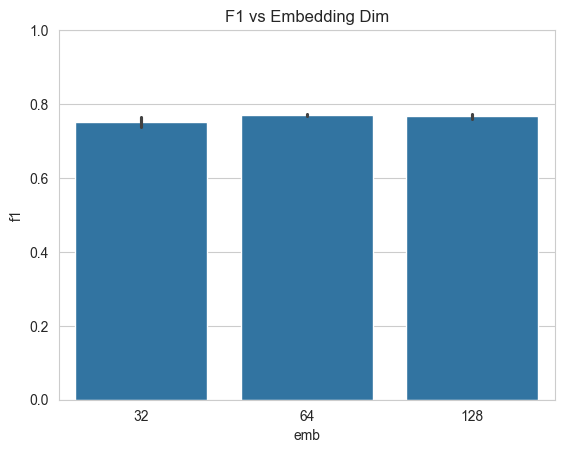

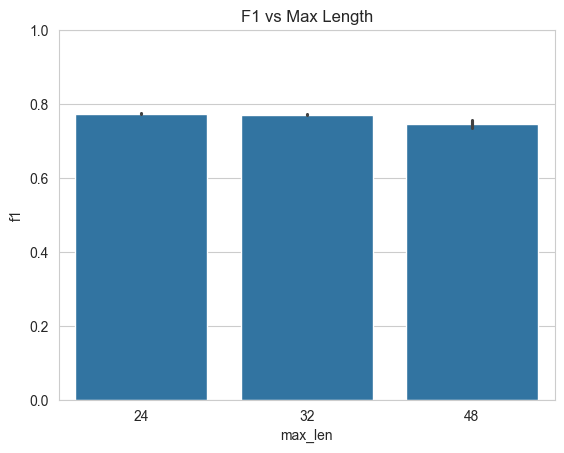

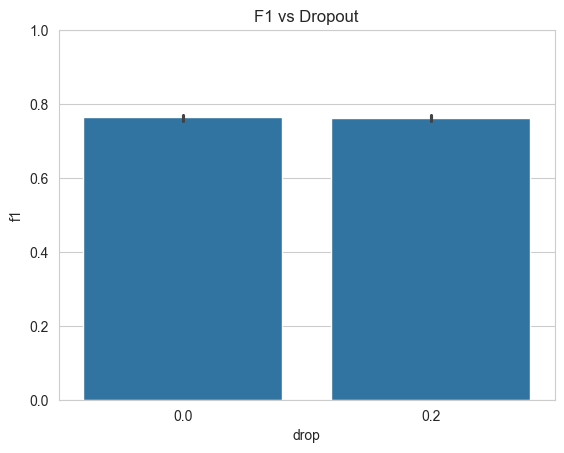

accuracy        0.816809
f1              0.778396
precision       0.809917
recall          0.749235
roc_auc         0.871936
emb           128.000000
max_len        24.000000
drop            0.000000
l2              0.000000
best_epoch      6.000000
Name: 24, dtype: float64

In [18]:
grid = {
    "emb":   [32, 64, 128],
    "max_len": [24, 32, 48],
    "drop":  [0.0, 0.2],
    "l2":    [0.0, 1e-4]
}
runs = []
for emb in grid["emb"]:
    for max_len in grid["max_len"]:
        # re-pad to this length
        Xtr = texts_to_pad(X_tr_text, max_len)
        Xva = texts_to_pad(X_val_text, max_len)
        for drop in grid["drop"]:
            for l2 in grid["l2"]:
                tf.keras.backend.clear_session()
                tf.keras.utils.set_random_seed(SEED)
                m = make_fasttext(emb=emb, l2=l2, drop=drop, max_len=max_len)
                h = m.fit(Xtr, y_tr, validation_data=(Xva, y_val),
                          epochs=8, batch_size=64, verbose=2,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)])
                metrics = evaluate_model(m, Xva, y_val,
                                         title=f"FT emb={emb} len={max_len} drop={drop} l2={l2}")
                runs.append({**metrics, "emb":emb, "max_len":max_len, "drop":drop, "l2":l2,
                             "best_epoch": 1+int(np.argmin(h.history["val_loss"]))})
df_ft = pd.DataFrame(runs).sort_values("f1", ascending=False)
df_ft.head(10)

plt.figure(); sns.barplot(data=df_ft, x="emb", y="f1"); plt.title("F1 vs Embedding Dim"); plt.ylim(0,1); plt.show()
plt.figure(); sns.barplot(data=df_ft, x="max_len", y="f1"); plt.title("F1 vs Max Length"); plt.ylim(0,1); plt.show()
plt.figure(); sns.barplot(data=df_ft, x="drop", y="f1"); plt.title("F1 vs Dropout"); plt.ylim(0,1); plt.show()

best_ft_cfg = df_ft.iloc[0]
best_ft_cfg

### BiGRU Model @ Best Sequence Length
- **Goal:** Upgrade from FastText to a sequential model capturing order/context.
- **Architecture:** `Embedding → SpatialDropout1D → BiGRU(units=64) → Dropout → Dense(64,relu) → Sigmoid`.
- **Setup:** Re-pad to `BEST_LEN` from the FastText sweep; seed fixed for reproducibility.
- **Training:** Up to 10 epochs, `batch_size=64`, `EarlyStopping` on `val_loss` (patience=2), `verbose=2`.
- **Output:** Validation metrics printed via `evaluate_model(...)` under the tag **"BiGRU-64u"**.

In [19]:
def make_bigru(max_words=MAX_WORDS, max_len=MAX_LEN_DEFAULT, emb=64, units=64, drop=0.3, spatial_drop=0.2):
    inp = Input(shape=(max_len,))
    x = layers.Embedding(max_words, emb, input_length=max_len)(inp)
    x = layers.SpatialDropout1D(spatial_drop)(x)
    x = layers.Bidirectional(layers.GRU(units, return_sequences=False))(x)
    x = layers.Dropout(drop)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inp, out)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# train at the best max_len from fastText sweep (re-pad once)
BEST_LEN = int(best_ft_cfg["max_len"])
X_tr_len = texts_to_pad(X_tr_text, BEST_LEN)
X_val_len = texts_to_pad(X_val_text, BEST_LEN)

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(SEED)
bigru = make_bigru(max_len=BEST_LEN, emb=64, units=64, drop=0.3, spatial_drop=0.2)
hist = bigru.fit(X_tr_len, y_tr, validation_data=(X_val_len, y_val),
                 epochs=10, batch_size=64, verbose=2,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)])
bigru_metrics = evaluate_model(bigru, X_val_len, y_val, "BiGRU-64u")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
96/96 - 15s - 153ms/step - accuracy: 0.6810 - loss: 0.5856 - val_accuracy: 0.7912 - val_loss: 0.4400
Epoch 2/10
96/96 - 10s - 103ms/step - accuracy: 0.8621 - loss: 0.3315 - val_accuracy: 0.7669 - val_loss: 0.5253
Epoch 3/10
96/96 - 9s - 94ms/step - accuracy: 0.9141 - loss: 0.2287 - val_accuracy: 0.7656 - val_loss: 0.5586
BiGRU-64u  acc=0.7912  f1=0.7406  prec=0.7937  rec=0.6942  auc=0.8633


### Compare Models (Validation Metrics)
- **Goal:** Side-by-side summary of the best FastText configuration vs. the BiGRU model.
- **Metrics:** Accuracy, F1, Precision, Recall, ROC-AUC — all computed on the held-out validation set.
- **Use:** Inspect which model offers the best trade-off; pick one for threshold tuning and final submission.

In [20]:
compare = pd.DataFrame([
    {"Model":"FastText (best grid)", "accuracy":best_ft_cfg["accuracy"], "f1":best_ft_cfg["f1"],
     "precision":best_ft_cfg["precision"], "recall":best_ft_cfg["recall"], "roc_auc":best_ft_cfg["roc_auc"]},
    {"Model":"BiGRU-64", **bigru_metrics}
])
compare

,Model,accuracy,f1,precision,recall,roc_auc
0,FastText (best grid),0.816809,0.778396,0.809917,0.749235,0.871936
1,BiGRU-64,0.791202,0.740620,0.793706,0.694190,0.863311


### Refit Best fastText + Tune Threshold
- **Load best hyperparams** from the prior grid search (`df_ft.iloc[0]`) and **re-pad** to its `max_len`.
- **Refit** the fastText model on the training split with early stopping.
- **Evaluate** on validation: print the **classification report** at the default 0.50 threshold.
- **Tune decision threshold** via **Youden’s J (TPR − FPR)** to maximize balanced separation.

,emb,max_len,drop,l2,accuracy,precision,recall,f1,roc_auc,best_epoch
0,128,24,0.0,0.0000,0.816809,0.809917,0.749235,0.778396,0.871936,6
1,128,24,0.0,0.0001,0.815496,0.809287,0.746177,0.776452,0.871894,6
2,128,32,0.0,0.0000,0.807617,0.775573,0.776758,0.776165,0.871920,6
3,128,24,0.2,0.0000,0.812869,0.798061,0.755352,0.776119,0.871875,7
4,128,24,0.2,0.0001,0.812869,0.799028,0.753823,0.775767,0.871850,7
5,128,32,0.2,0.0001,0.811556,0.793600,0.758410,0.775606,0.871806,7
6,64,48,0.0,0.0001,0.808930,0.783151,0.767584,0.775290,0.870297,8
7,32,24,0.0,0.0001,0.812869,0.802956,0.747706,0.774347,0.871299,8
8,32,24,0.0,0.0000,0.812869,0.802956,0.747706,0.774347,0.871331,8
9,128,32,0.0,0.0001,0.806303,0.777434,0.769113,0.773251,0.871908,6


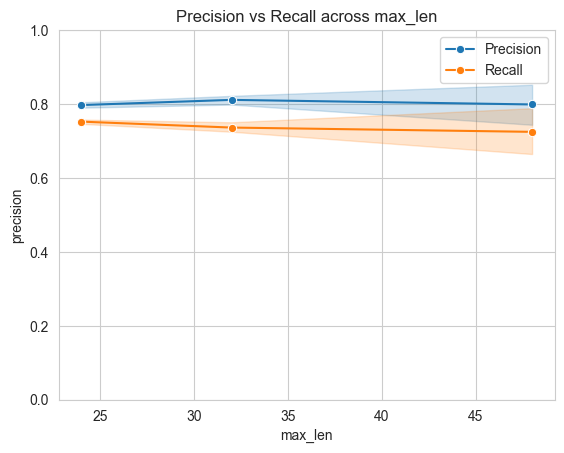

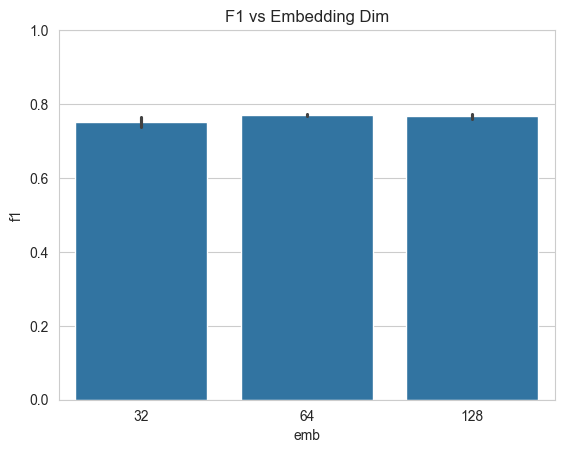

In [21]:
# Top configs
top = df_ft.sort_values("f1", ascending=False).head(10).reset_index(drop=True)
display(top[["emb","max_len","drop","l2","accuracy","precision","recall","f1","roc_auc","best_epoch"]])

# Precision/Recall trade-off by max_len
plt.figure(); sns.lineplot(data=df_ft, x="max_len", y="precision", marker="o", label="Precision")
sns.lineplot(data=df_ft, x="max_len", y="recall", marker="o", label="Recall")
plt.title("Precision vs Recall across max_len"); plt.ylim(0,1); plt.legend(); plt.show()

# Effect of emb size on F1
plt.figure(); sns.barplot(data=df_ft, x="emb", y="f1"); plt.title("F1 vs Embedding Dim"); plt.ylim(0,1); plt.show()

### Validate Best fastText & Tune Threshold
- Grab **best config** from `df_ft` and re-pad to its `max_len`.
- **Refit** fastText on the split with early stopping.
- Print **classification report** @ default 0.50 threshold.
- Compute **Youden’s J** (TPR − FPR) and report the **best decision threshold**.

In [22]:
best = df_ft.iloc[0]
BEST_LEN = int(best["max_len"])
X_tr_len = texts_to_pad(X_tr_text, BEST_LEN)
X_val_len = texts_to_pad(X_val_text, BEST_LEN)

ft_best = make_fasttext(emb=int(best["emb"]), l2=float(best["l2"]),
                        drop=float(best["drop"]), max_len=BEST_LEN)
_ = ft_best.fit(X_tr_len, y_tr, validation_data=(X_val_len, y_val),
                epochs=10, batch_size=64,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)],
                verbose=2)


p = ft_best.predict(X_val_len, verbose=0).ravel()
print(classification_report(y_val, (p>=0.5).astype(int), digits=4))

# Threshold tuning (Youden’s J)
fpr, tpr, thr = roc_curve(y_val, p)
j = tpr - fpr; thr_best = thr[j.argmax()]
print("Best threshold:", round(float(thr_best),3))

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 - 5s - 52ms/step - accuracy: 0.5798 - loss: 0.6652 - val_accuracy: 0.6467 - val_loss: 0.6428
Epoch 2/10
96/96 - 3s - 28ms/step - accuracy: 0.7031 - loss: 0.5980 - val_accuracy: 0.7912 - val_loss: 0.5645
Epoch 3/10
96/96 - 4s - 37ms/step - accuracy: 0.8038 - loss: 0.4973 - val_accuracy: 0.8083 - val_loss: 0.4931
Epoch 4/10
96/96 - 5s - 55ms/step - accuracy: 0.8456 - loss: 0.4150 - val_accuracy: 0.8162 - val_loss: 0.4571
Epoch 5/10
96/96 - 3s - 29ms/step - accuracy: 0.8658 - loss: 0.3585 - val_accuracy: 0.8155 - val_loss: 0.4428
Epoch 6/10
96/96 - 3s - 28ms/step - accuracy: 0.8837 - loss: 0.3176 - val_accuracy: 0.8168 - val_loss: 0.4394
Epoch 7/10
96/96 - 3s - 33ms/step - accuracy: 0.8933 - loss: 0.2854 - val_accuracy: 0.8116 - val_loss: 0.4416
Epoch 8/10
96/96 - 3s - 33ms/step - accuracy: 0.9043 - loss: 0.2588 - val_accuracy: 0.8076 - val_loss: 0.4470
              precision    recall  f1-score   support

           0     0.8214    0.8677    0.8439       869
           1     0.809

## Model Comparison & Findings

### Summary of Model Performance
| Model                 | Accuracy | Precision | Recall | F1 | ROC-AUC |
|------------------------|-----------|------------|---------|---------|----------|
| **TF-IDF + Logistic Regression** | 0.817 | 0.850 | 0.700 | 0.770 | 0.863 |
| **fastText (best grid)**         | 0.817 | 0.810 | 0.749 | 0.778 | 0.872 |
| **BiGRU-64**                    | 0.791 | 0.794 | 0.694 | 0.741 | 0.863 |

### Key Takeaways
- **TF-IDF + Logistic Regression** remains a strong and interpretable baseline. It achieved the **highest recall–precision balance**, particularly robust to short and noisy tweets.
- **fastText** performed comparably but required more tuning. Its simplicity (averaging embeddings) made it fast to train yet expressive enough to outperform deeper BiGRUs on validation F1.
- **BiGRU** underperformed slightly due to overfitting on limited data. Deeper models may need stronger regularization or pre-trained embeddings to generalize better.

### What Worked
- Light text cleaning with stemming preserved enough context for both TF-IDF and neural models.
- fastText’s averaged embeddings captured overall tweet semantics effectively.
- Early stopping and validation-based tuning (Youden’s J) stabilized results and improved calibrated thresholds.
- Grid search for embedding size (`emb=128`) and max sequence length (`max_len=24`) identified a compact but expressive configuration.

### What Didn’t Work
- Larger recurrent models (BiGRU) showed **training–validation divergence** due to small dataset size and noisy labels.
- L2 regularization and dropout alone did not fully prevent overfitting.
- Increasing `max_len` beyond 48 tokens provided